In [3]:
import sys
sys.path.append('..')
from utils import *
import pandas as pd
import matplotlib as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error


class AntiChessNNet(nn.Module):
    def __init__(self, game, args):
        # game params
        self.board_x, self.board_y = game.getBoardSize()
        self.action_size = game.getActionSize()
        self.args = args

        super(AntiChessNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, args.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1)
        self.conv4 = nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1)

        self.bn1 = nn.BatchNorm2d(args.num_channels)
        self.bn2 = nn.BatchNorm2d(args.num_channels)
        self.bn3 = nn.BatchNorm2d(args.num_channels)
        self.bn4 = nn.BatchNorm2d(args.num_channels)

        self.fc1 = nn.Linear(args.num_channels*(self.board_x-4)*(self.board_y-4), 1024)
        self.fc_bn1 = nn.BatchNorm1d(1024)

        self.fc2 = nn.Linear(1024, 512)
        self.fc_bn2 = nn.BatchNorm1d(512)

        self.fc3 = nn.Linear(512, self.action_size)

        self.fc4 = nn.Linear(512, 1)

    def forward(self, s):
        #                                                           s: batch_size x board_x x board_y
        s = s.view(-1, 1, self.board_x, self.board_y)                # batch_size x 1 x board_x x board_y
        s = F.relu(self.bn1(self.conv1(s)))                          # batch_size x num_channels x board_x x board_y
        s = F.relu(self.bn2(self.conv2(s)))                          # batch_size x num_channels x board_x x board_y
        s = F.relu(self.bn3(self.conv3(s)))                          # batch_size x num_channels x (board_x-2) x (board_y-2)
        s = F.relu(self.bn4(self.conv4(s)))                          # batch_size x num_channels x (board_x-4) x (board_y-4)
        s = s.view(-1, self.args.num_channels*(self.board_x-4)*(self.board_y-4))

        s = F.dropout(F.relu(self.fc_bn1(self.fc1(s))), p=self.args.dropout, training=self.training)  # batch_size x 1024
        s = F.dropout(F.relu(self.fc_bn2(self.fc2(s))), p=self.args.dropout, training=self.training)  # batch_size x 512

        pi = self.fc3(s)                                                                         # batch_size x action_size
        v = self.fc4(s)                                                                          # batch_size x 1

        return F.log_softmax(pi, dim=1), torch.tanh(v)


In [4]:
import os
import sys
import time
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
from tqdm import tqdm

sys.path.append('../../')
from utils import *
from NeuralNet import NeuralNet

import torch
import torch.optim as optim


args = dotdict({
    'lr': 0.2,
    'dropout': 0.3,
    'epochs': 1,
    'batch_size': 64,
    'cuda': torch.cuda.is_available(),
    'num_channels': 512,
})


class NNetWrapper(NeuralNet):
    def __init__(self, game):
        self.nnet = AntiChessNNet(game, args)
        self.board_x, self.board_y = game.getBoardSize()
        self.action_size = game.getActionSize()

        if args.cuda:
            self.nnet.cuda()

    def train(self, examples):
        """
        examples: list of examples, each example is of form (board, pi, v)
        """
        optimizer = optim.Adam(self.nnet.parameters())

        for epoch in range(args.epochs):
            print('EPOCH ::: ' + str(epoch + 1))
            self.nnet.train()
            pi_losses = AverageMeter()
            v_losses = AverageMeter()

            batch_count = int(len(examples) / args.batch_size)

            t = tqdm(range(batch_count), desc='Training Net')
            for _ in t:
                sample_ids = np.random.randint(len(examples), size=args.batch_size)
                boards, pis, vs = list(zip(*[examples[i] for i in sample_ids]))
                boards = [board.pieces for board in boards]
                boards = torch.FloatTensor(np.array(boards).astype(np.float64))
                target_pis = torch.FloatTensor(np.array(pis))
                target_vs = torch.FloatTensor(np.array(vs).astype(np.float64))

                # predict
                if args.cuda:
                    boards, target_pis, target_vs = boards.contiguous().cuda(), target_pis.contiguous().cuda(), target_vs.contiguous().cuda()

                # compute output
                out_pi, out_v = self.nnet(boards)
                l_pi = self.loss_pi(target_pis, out_pi)
                l_v = self.loss_v(target_vs, out_v)
                total_loss = l_pi + l_v

                # record loss
                pi_losses.update(l_pi.item(), boards.size(0))
                v_losses.update(l_v.item(), boards.size(0))
                t.set_postfix(Loss_pi=pi_losses, Loss_v=v_losses)

                # compute gradient and do SGD step
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

    def predict(self, board):
        """
        board: np array with board
        """
        # timing

        # preparing input
        board = torch.FloatTensor(board.pieces.astype(np.float64))
        if args.cuda: board = board.contiguous().cuda()
        board = board.view(1, self.board_x, self.board_y)
        self.nnet.eval()
        with torch.no_grad():
            pi, v = self.nnet(board)

        # print('PREDICTION TIME TAKEN : {0:03f}'.format(time.time()-start))
        return torch.exp(pi).data.cpu().numpy()[0], v.data.cpu().numpy()[0]

    def loss_pi(self, targets, outputs):
        return -torch.sum(targets * outputs) / targets.size()[0]

    def loss_v(self, targets, outputs):
        return torch.sum((targets - outputs.view(-1)) ** 2) / targets.size()[0]

    def save_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
        filepath = os.path.join(folder, filename)
        if not os.path.exists(folder):
            print("Checkpoint Directory does not exist! Making directory {}".format(folder))
            os.mkdir(folder)
        else:
            print("Checkpoint Directory exists! ")
        torch.save({
            'state_dict': self.nnet.state_dict(),
        }, filepath)

    def load_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
        # https://github.com/pytorch/examples/blob/master/imagenet/main.py#L98
        filepath = os.path.join(folder, filename)
        if not os.path.exists(filepath):
            raise ("No model in path {}".format(filepath))
        map_location = None if args.cuda else 'cpu'
        checkpoint = torch.load(filepath, map_location=map_location)
        self.nnet.load_state_dict(checkpoint['state_dict'])


In [5]:
# https://stackoverflow.com/questions/2267362/how-to-convert-an-integer-in-any-base-to-a-string

import string

digs = string.digits + string.ascii_letters


def int2base(x, base, length):
    if x < 0:
        sign = -1
    elif x == 0:
        return digs[0]
    else:
        sign = 1

    x *= sign
    digits = []

    while x:
        digits.append(digs[int(x % base)])
        x = int(x / base)

    if sign < 0:
        digits.append('-')

    while len(digits) < length: digits.extend(["0"])

    return list(map(lambda x: int(x), digits))


FILE_MAP = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7}
RANK_MAP = {'1': 7, '2': 6, '3': 5, '4': 4, '5': 3, '6': 2, '7': 1, '8': 0}

RESIDUALS_MAP = {0.875 : 7, 0.75 : 6, 0.625 : 5, 0.5 : 4,0.375 : 3, 0.25 : 2, 0.125 : 1, 0.0 : 0}
PIECE_MAP = {"r" : -4, "n" : -2, "b": -3, "q" : -5, "k" : -6, "p" : -1, "R" : 4, "N" : 2, "B": 3, "Q" : 5, "K" : 6, "P" : 1}

FILE_MAP_REVERSE = {v: k for k, v in FILE_MAP.items()}
RANK_MAP_REVERSE = {v: k for k, v in RANK_MAP.items()}

PIECE_MAP = {"p" : 1, "P" : -1, "R" : -4, "r" : 4, "N" : -2, "n" : 2, "B" : -3, "b" : 3, "Q" : -5, "q" : 5, "K" : -6, "k" : 6}


PROMOTIONS = {'a2a1q': 0,
             'a2a1r': 11,
             'a2a1k': 12,
             'a2a1b': 13,
             'a2a1n': 14,
             'a2b1q': 15,
             'a2b1r': 19,
             'a2b1k': 20,
             'a2b1b': 21,
             'a2b1n': 22,
             'a7a8q': 23,
             'a7a8r': 25,
             'a7a8k': 26,
             'a7a8b': 28,
             'a7a8n': 29,
             'a7b8q': 30,
             'a7b8r': 31,
             'a7b8k': 33,
             'a7b8b': 34,
             'a7b8n': 35,
             'b2a1q': 37,
             'b2a1r': 38,
             'b2a1k': 39,
             'b2a1b': 41,
             'b2a1n': 42,
             'b2b1q': 43,
             'b2b1r': 44,
             'b2b1k': 46,
             'b2b1b': 47,
             'b2b1n': 49,
             'b2c1q': 50,
             'b2c1r': 51,
             'b2c1k': 52,
             'b2c1b': 53,
             'b2c1n': 55,
             'b7a8q': 57,
             'b7a8r': 58,
             'b7a8k': 59,
             'b7a8b': 60,
             'b7a8n': 61,
             'b7b8q': 62,
             'b7b8r': 65,
             'b7b8k': 76,
             'b7b8b': 77,
             'b7b8n': 78,
             'b7c8q': 79,
             'b7c8r': 84,
             'b7c8k': 85,
             'b7c8b': 86,
             'b7c8n': 87,
             'c2b1q': 88,
             'c2b1r': 90,
             'c2b1k': 91,
             'c2b1b': 93,
             'c2b1n': 94,
             'c2c1q': 95,
             'c2c1r': 96,
             'c2c1k': 98,
             'c2c1b': 99,
             'c2c1n': 100,
             'c2d1q': 102,
             'c2d1r': 103,
             'c2d1k': 104,
             'c2d1b': 106,
             'c2d1n': 107,
             'c7b8q': 108,
             'c7b8r': 109,
             'c7b8k': 111,
             'c7b8b': 112,
             'c7b8n': 114,
             'c7c8q': 115,
             'c7c8r': 116,
             'c7c8k': 117,
             'c7c8b': 118,
             'c7c8n': 120,
             'c7d8q': 122,
             'c7d8r': 123,
             'c7d8k': 124,
             'c7d8b': 125,
             'c7d8n': 126,
             'd2c1q': 127,
             'd2c1r': 130,
             'd2c1k': 141,
             'd2c1b': 142,
             'd2c1n': 143,
             'd2d1q': 149,
             'd2d1r': 150,
             'd2d1k': 151,
             'd2d1b': 152,
             'd2d1n': 153,
             'd2e1q': 155,
             'd2e1r': 156,
             'd2e1k': 158,
             'd2e1b': 159,
             'd2e1n': 160,
             'd7c8q': 161,
             'd7c8r': 163,
             'd7c8k': 164,
             'd7c8b': 165,
             'd7c8n': 167,
             'd7d8q': 168,
             'd7d8r': 169,
             'd7d8k': 171,
             'd7d8b': 172,
             'd7d8n': 173,
             'd7e8q': 174,
             'd7e8r': 176,
             'd7e8k': 177,
             'd7e8b': 179,
             'd7e8n': 180,
             'e2d1q': 181,
             'e2d1r': 182,
             'e2d1k': 183,
             'e2d1b': 184,
             'e2d1n': 185,
             'e2e1q': 187,
             'e2e1r': 188,
             'e2e1k': 189,
             'e2e1b': 190,
             'e2e1n': 191,
             'e2f1q': 195,
             'e2f1r': 200,
             'e2f1k': 206,
             'e2f1b': 207,
             'e2f1n': 208,
             'e7d8q': 214,
             'e7d8r': 215,
             'e7d8k': 217,
             'e7d8b': 218,
             'e7d8n': 220,
             'e7e8q': 221,
             'e7e8r': 223,
             'e7e8k': 224,
             'e7e8b': 225,
             'e7e8n': 226,
             'e7f8q': 228,
             'e7f8r': 229,
             'e7f8k': 230,
             'e7f8b': 232,
             'e7f8n': 233,
             'f2e1q': 234,
             'f2e1r': 236,
             'f2e1k': 237,
             'f2e1b': 238,
             'f2e1n': 239,
             'f2f1q': 240,
             'f2f1r': 241,
             'f2f1k': 242,
             'f2f1b': 244,
             'f2f1n': 245,
             'f2g1q': 246,
             'f2g1r': 247,
             'f2g1k': 248,
             'f2g1b': 249,
             'f2g1n': 250,
             'f7e8q': 252,
             'f7e8r': 253,
             'f7e8k': 254,
             'f7e8b': 255,
             'f7e8n': 260,
             'f7f8q': 264,
             'f7f8r': 265,
             'f7f8k': 271,
             'f7f8b': 272,
             'f7f8n': 273,
             'f7g8q': 279,
             'f7g8r': 280,
             'f7g8k': 282,
             'f7g8b': 283,
             'f7g8n': 285,
             'g2f1q': 286,
             'g2f1r': 289,
             'g2f1k': 290,
             'g2f1b': 291,
             'g2f1n': 293,
             'g2g1q': 294,
             'g2g1r': 295,
             'g2g1k': 296,
             'g2g1b': 297,
             'g2g1n': 298,
             'g2h1q': 299,
             'g2h1r': 301,
             'g2h1k': 302,
             'g2h1b': 303,
             'g2h1n': 304,
             'g7f8q': 305,
             'g7f8r': 306,
             'g7f8k': 307,
             'g7f8b': 309,
             'g7f8n': 310,
             'g7g8q': 311,
             'g7g8r': 312,
             'g7g8k': 313,
             'g7g8b': 314,
             'g7g8n': 315,
             'g7h8q': 317,
             'g7h8r': 318,
             'g7h8k': 319,
             'g7h8b': 325,
             'g7h8n': 328,
             'h2g1q': 329,
             'h2g1r': 330,
             'h2g1k': 336,
             'h2g1b': 337,
             'h2g1n': 338,
             'h2h1q': 344,
             'h2h1r': 345,
             'h2h1k': 347,
             'h2h1b': 348,
             'h2h1n': 350,
             'h7g8q': 351,
             'h7g8r': 352,
             'h7g8k': 354,
             'h7g8b': 355,
             'h7g8n': 356,
             'h7h8q': 358,
             'h7h8r': 359,
             'h7h8k': 361,
             'h7h8b': 362,
             'h7h8n': 363}

REVERSE_PROMOTIONS = {v: k for k, v in PROMOTIONS.items()}
REVERSE_PIECE_MAP = {v: k for k, v in PIECE_MAP.items()}

def get_move_from_action(action):    
    if action in REVERSE_PROMOTIONS:
        move = REVERSE_PROMOTIONS[action]

    else:
        move = int2base(action, 8, 4)
        move = FILE_MAP_REVERSE[move[0]]+""+RANK_MAP_REVERSE[move[1]]+""+FILE_MAP_REVERSE[move[2]]+""+RANK_MAP_REVERSE[move[3]]
        
    return move

def get_action_from_move(move):

    action = -1
    if len(move) > 4:
        action = PROMOTIONS[move]
    else:
        x1, y1, x2, y2 = FILE_MAP[move[0]],RANK_MAP[move[1]],FILE_MAP[move[2]],RANK_MAP[move[3]]
        action = x1 + y1 * 8 + x2 * 8 ** 2 + y2 * 8 ** 3
    
    return action


book1 = [('Nh3', 0.5712763079410298, 613598),
 ('g4', 0.5593962228771996, 511977),
 ('c4', 0.5575896103276872, 671128),
 ('e3', 0.5400545955905178, 6281826),
 ('Na3', 0.5120225422667501, 143730),
 ('g3', 0.5033715727067002, 2752573),
 ('b3', 0.5030213830888164, 1471677)]

book2 = {'Nh3': [('b6', 0.5233891279252807, 76232), ('e6', 0.4909453202836547, 85315)],
 'Na3': [('b5', 0.522741518942908, 79766), ('e6', 0.43458378859617175, 24711)],
 'g3': [('b6', 0.5142890497314966, 642450),
  ('e6', 0.5079845259703353, 272715),
  ('b5', 0.4958576700310369, 81838),
  ('g5', 0.481261861764264, 326153),
  ('g6', 0.4464190490700737, 735112),
  ('Nh6', 0.4197372307771342, 155726),
  ('c5', 0.41346334331130274, 101223)],
 'g4': [('b6', 0.508440257030104, 48399), ('g6', 0.43230419422730004, 106432)],
 'b3': [('g6', 0.5080923761298566, 295834),
  ('b5', 0.470743616835756, 194966),
  ('Na6', 0.4641160949868074, 41690),
  ('b6', 0.4623230805724678, 354116),
  ('e6', 0.45675518025688905, 255441),
  ('c5', 0.39718369198859216, 61712)],
 'e3': [('b5', 0.5002405564398114, 4287975),
  ('g5', 0.4959632008882544, 63045),
  ('c5', 0.4866542046567225, 314556)],
 'c4': [('g6', 0.4939559529723464, 54351),
  ('c5', 0.4887156775907883, 28225),
  ('e6', 0.48395434612145327, 34433),
  ('c6', 0.47802340060905696, 81109)]}


book3 = {'c4g6': [('a4', 0.6381637028629084, 7929),
  ('e3', 0.5451866404715128, 6108),
  ('c5', 0.5006047899362954, 12401)],
 'b3b6': [('c4', 0.6359555079067274, 14924),
  ('Na3', 0.5247058823529411, 9775),
  ('e3', 0.5061101332662811, 19885),
  ('b4', 0.4909090909090909, 37840)],
 'g3e6': [('b4', 0.6316940149021786, 169237)],
 'b3g6': [('e3', 0.6262023789001896, 29005),
  ('c4', 0.5560526969922943, 8046),
  ('Na3', 0.5364141084258655, 6124),
  ('g4', 0.5229966634099582, 54247),
  ('g3', 0.5040465690597989, 141725)],
  'b3c5' :  [('b4', 0.3600178826895565, 343434)], #move added
 'g3b6': [('c4', 0.6169710650523291, 19492),
  ('Nh3', 0.6117384179949352, 33565),
  ('b3', 0.5372625389295971, 395907),
  ('b4', 0.49710701346455416, 73972)],
 'Nh3b6': [('Nf4', 0.6018914658860617, 4441),
  ('g3', 0.5712875885289679, 34452)],
 'g3b5': [('Nh3', 0.5986410496719775, 4268),
  ('b3', 0.5488695284116962, 28351)],
 'e3c5': [('Bd3', 0.5886844526218952, 21740),
  ('Bb5', 0.513766309391662, 54953),
  ('Bc4', 0.4956475863888156, 7582)],
 'g4b6': [('g5', 0.5592344598513207, 18967),
  ('c4', 0.515621383938903, 4321),
  ('b3', 0.5153460147041662, 8569)],
 'g3g6': [('Nh3', 0.5500178826895565, 55920)],
 'g3g5': [('b3', 0.5413560477912909, 149567),
  ('c4', 0.5176667681998173, 6566)],
 'c4c6': [('Qb3', 0.5360107095046854, 7470),
  ('g3', 0.49665551839464883, 13156),
  ('Na3', 0.4920952571542926, 9994)],
 'b3e6': [('e3', 0.5358708189158016, 8670), ('b4', 0.49342499095484, 152015)],
 'g3Nh6': [('d3', 0.5348615090735435, 8376),
  ('Nh3', 0.49551020408163265, 8575)],
 'b3b5': [('a4', 0.5239007468578899, 77257)],
 'e3g5': [('Ba6', 0.5230626234460323, 51642)],
 'Na3b5': [('Nxb5', 0.5226981373953699, 79566)],
 'Na3e6': [('b4', 0.4626981373953699, 16000)], #move added
 'g3c5': [('Nh3', 0.5112291716976576, 8282),
  ('c3', 0.49405964600339447, 12373)],
 'c4c5': [('b4', 0.508867515427809, 17987)],
 'g4g6': [('Nh3', 0.5059642147117296, 11066)],
 'c4e6': [('c5', 0.5035268817204301, 23250)],
 'e3b5': [('Bxb5', 0.5004159487016842, 4281778)],
 'Nh3e6': [('Ng5', 0.49984267164523505, 47671)],
 'b3Na6': [('g3', 0.49800148038490005, 6755)]}

book4 = {'b3b6Na3': [('g6', 0.5496535796766744, 2598),
  ('b5', 0.5089748703629836, 5014)],
 'b3g6Na3': [('b5', 0.5488435374149659, 3675)],
 'Na3b5Nxb5': [('d6', 0.5484496124031008, 2064),
  ('a6', 0.5210205316821082, 21479),
  ('g5', 0.5148188803512623, 911),
  ('e6', 0.5055884286653517, 4563),
  ('g6', 0.4986753017368266, 6794),
  ('c6', 0.49092588926285224, 15153),
  ('Bb7', 0.4844649021864212, 8690),
  ('Nh6', 0.4797979797979798, 1386)],
 'g3c5Nh3': [('g5', 0.547707100591716, 2704), ('c4', 0.500438596491228, 2280)],
 'g3g5b3': [('h5', 0.5456081081081081, 1184),
  ('b5', 0.5452996646880731, 92153),
  ('b6', 0.5388299851190477, 21504),
  ('Nh6', 0.5020785219399538, 2165),
  ('a6', 0.4605263157894737, 836),
  ('c5', 0.43672537508153947, 9198)],
 'g3e6b4' : [('Bxb4',0.65,85000)], #move added
 'c4g6c5': [('d6', 0.5450292397660819, 855),
  ('c6', 0.5260232440626579, 5937),
  ('b6', 0.4218248509857863, 4362)],
 'g3b6b3': [('Nh6', 0.5446623093681917, 2754),
  ('g6', 0.5417104433704559, 233191),
  ('e5', 0.5404651162790698, 2150),
  ('g5', 0.5098690735965087, 40328),
  ('b5', 0.5019659239842726, 6104),
  ('e6', 0.45127866688665236, 30305),
  ('c5', 0.43456435998565796, 8367),
  ('Na6', 0.4312586022327573, 13078),
  ('a5', 0.41856586992773764, 3598)],
 'e3c5Bd3': [('h5', 0.5419520547945206, 1168),
  ('a5', 0.49820750738085195, 9484)],
 'e3b5Bxb5': [('a5', 0.5398130841121496, 5350),
  ('c6', 0.534215136540309, 318514),
  ('h5', 0.5209603140649772, 198685),
  ('c5', 0.520682503032912, 25553),
  ('Ba6', 0.5159343554741411, 398510),
  ('g5', 0.4774140656493598, 220779),
  ('Bb7', 0.46449888798869665, 1075079),
  ('e6', 0.46372888559907355, 1110498),
  ('e5', 0.42771550770592137, 54244),
  ('Nh6', 0.4026486996224762, 314947)],
 'b3e6e3': [('Ba3', 0.5394996708360764, 6076),
  ('b5', 0.4649425287356322, 1740)],
 'c4g6a4': [('c6', 0.538878842676311, 1106)],
 'g4g6Nh3': [('g5', 0.5369484316852738, 3762),
  ('h5', 0.3994227994227994, 3465)],
 'c4c6Qb3': [('g6', 0.5345528455284553, 984),
  ('b5', 0.48127880184331795, 3472)],
 'b3g6e3': [('b5', 0.5317415001297691, 19265)],
 'g3b5b3': [('c6', 0.5306345733041575, 914),
  ('c5', 0.5285839929639402, 2274),
  ('Na6', 0.41935483870967744, 2511),
  ('f5', 0.36718115353371245, 3693)],
 'g3b6b4': [('e6', 0.5300638226402419, 2977),
  ('g5', 0.4925568655472192, 8397),
  ('g6', 0.45753402528169296, 24761),
  ('a5', 0.4547487884687073, 24143)],
 'b3g6g3': [('b6', 0.5272677171271826, 79838),
  ('g5', 0.48231884057971014, 1725),
  ('b5', 0.4515164835164835, 11375),
  ('e6', 0.44247891283973756, 8536),
  ('d6', 0.4046783625730994, 5130),
  ('c5', 0.33224596313815036, 6131),
  ('Nh6', 0.3031490741992161, 7399)],
 'b3g6g4': [('b5', 0.5249866619242397, 5623),
  ('b6', 0.4823086010012938, 17777),
  ('h5', 0.48104812129202373, 18204),
  ('c5', 0.3928150765606596, 1698)],
 'b3b5a4': [('bxa4', 0.5239007468578899, 77257)],
 'e3c5Bb5': [('h5', 0.520891364902507, 1077),
  ('g5', 0.5171171171171172, 1665),
  ('c4', 0.4932769395871473, 15841),
  ('Nh6', 0.4837662337662338, 1540),
  ('Qc7', 0.44179875206196656, 13943),
  ('a5', 0.39246178176067475, 3794)],
 'g3g5c4': [('b5', 0.5138721351025332, 4145)],
 'g4b6g5': [('g6', 0.5118674798088018, 12134)],
 'Nh3b6Nf4': [('d5', 0.5106970324361628, 1449)],
 'c4c5b4': [('cxb4', 0.508867515427809, 17987)],
 'g3c5c3': [('Nc6', 0.5057899090157155, 2418),
  ('g5', 0.5051993067590987, 1154),
  ('Na6', 0.4551219512195122, 2050),
  ('Qb6', 0.41359447004608296, 868),
  ('g6', 0.4053058216654385, 1357)],
 'c4g6e3': [('g5', 0.5041518386714117, 843),
  ('b5', 0.49504950495049505, 3636)],
 'c4e6c5': [('Bxc5', 0.5035268817204301, 23250)],
 'Nh3b6g3': [('e6', 0.5014156285390714, 3532)],
 'Nh3e6Ng5': [('Qxg5', 0.49984267164523505, 47671)],
 'b3b6b4': [('g5', 0.49654491609081935, 1013),
  ('a5', 0.4599132503148174, 14294),
  ('g6', 0.43541324575807333, 14616)],
 'g4b6b3': [('g6', 0.4945748170577845, 3963),
  ('f5', 0.4936092513694461, 1643)],
 'b3b6e3': [('Na6', 0.49361702127659574, 1410),
  ('b5', 0.4372466417613862, 12581)],
 'b3e6b4': [('Bxb4', 0.49342499095484, 152015)],
 'c4c6g3': [('b5', 0.49159327461969576, 1249),
  ('g6', 0.48589796764827875, 4822),
  ('g5', 0.4839071856287425, 2672)],
 'g3g6Nh3': [('Nh6', 0.48918734350102433, 4393),
  ('d6', 0.4500654164849542, 4586),
  ('c5', 0.4324580828851629, 3161)],
 'e3g5Ba6': [('Nxa6', 0.4829725313999796, 39172)],
 'g3Nh6d3': [('g5', 0.4784345047923323, 6260)],
 'c4c6Na3': [('b5', 0.47724801987886317, 6439),
  ('g6', 0.44306418219461696, 966)],
 'g4b6c4': [('b5', 0.4675223648385842, 2571)],
 'g3b6c4' : [('b5', 0.5975223648385842, 11111)], # mvoe added
 'Na3e6b4' : [('Bxb4', 0.4675223648385842, 16111)], #move addded
 'g3b5Nh3' : [('g5', 0.6275223648385842, 2000)], #move addded
 'b3b6c4'  : [('b5', 0.6075223648385842, 8000)], #move addded
 'b3c5b4' : [('cxb4', 0.3675223648385842, 34000)], #move addded
 'g3b6Nh3': [('e6', 0.46467817896389324, 3185)],
 'e3c5Bc4': [('d5', 0.4586518415566366, 2878)],
 'g3Nh6Nh3': [('g5', 0.44689626727160237, 4849)],
 'b3g6c4' : [('b5', 0.40689626727160237, 1000)], #move added
 'b3Na6g3': [('b6', 0.3951727401798391, 2113)]}

In [6]:
import os
import sys
import time

import numpy as np
from tqdm import tqdm

sys.path.append('../../')
from utils import *
from NeuralNet import NeuralNet

import torch
import torch.optim as optim

args = dotdict({
    'lr': 0.01,
    'dropout': 0.3,
    'epochs': 10,
    'batch_size': 64,
    'cuda': torch.cuda.is_available(),
    'num_channels': 512,
})


class NNetWrapper(NeuralNet):
    def __init__(self, game):
        self.nnet = AntiChessNNet(game, args)
        self.board_x, self.board_y = game.getBoardSize()
        self.action_size = game.getActionSize()

        if args.cuda:
            self.nnet.cuda()

    def train(self, examples):
        """
        examples: list of examples, each example is of form (board, pi, v)
        """
        optimizer = optim.Adam(self.nnet.parameters())

        for epoch in range(args.epochs):
            print('EPOCH ::: ' + str(epoch + 1))
            self.nnet.train()
            pi_losses = AverageMeter()
            v_losses = AverageMeter()

            batch_count = int(len(examples) / args.batch_size)

            t = tqdm(range(batch_count), desc='Training Net')
            for _ in t:
                sample_ids = np.random.randint(len(examples), size=args.batch_size)
                boards, pis, vs = list(zip(*[examples[i] for i in sample_ids]))
                boards = [board.pieces for board in boards]
                boards = torch.FloatTensor(np.array(boards).astype(np.float64))
                target_pis = torch.FloatTensor(np.array(pis))
                target_vs = torch.FloatTensor(np.array(vs).astype(np.float64))

                # predict
                if args.cuda:
                    boards, target_pis, target_vs = boards.contiguous().cuda(), target_pis.contiguous().cuda(), target_vs.contiguous().cuda()

                # compute output
                out_pi, out_v = self.nnet(boards)
                l_pi = self.loss_pi(target_pis, out_pi)
                l_v = self.loss_v(target_vs, out_v)
                total_loss = l_pi + l_v

                # record loss
                pi_losses.update(l_pi.item(), boards.size(0))
                v_losses.update(l_v.item(), boards.size(0))
                t.set_postfix(Loss_pi=pi_losses, Loss_v=v_losses)

                # compute gradient and do SGD step
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

    def predict(self, board):
        """
        board: np array with board
        """
        # timing

        # preparing input
        board = torch.FloatTensor(board.pieces.astype(np.float64))
        if args.cuda: board = board.contiguous().cuda()
        board = board.view(1, self.board_x, self.board_y)
        self.nnet.eval()
        with torch.no_grad():
            pi, v = self.nnet(board)

        # print('PREDICTION TIME TAKEN : {0:03f}'.format(time.time()-start))
        return torch.exp(pi).data.cpu().numpy()[0], v.data.cpu().numpy()[0]

    def loss_pi(self, targets, outputs):
        return -torch.sum(targets * outputs) / targets.size()[0]

    def loss_v(self, targets, outputs):
        return torch.sum((targets - outputs.view(-1)) ** 2) / targets.size()[0]

    def save_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
        filepath = os.path.join(folder, filename)
        if not os.path.exists(folder):
            print("Checkpoint Directory does not exist! Making directory {}".format(folder))
            os.mkdir(folder)
        else:
            print("Checkpoint Directory exists! ")
        torch.save({
            'state_dict': self.nnet.state_dict(),
        }, filepath)

    def load_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
        # https://github.com/pytorch/examples/blob/master/imagenet/main.py#L98
        filepath = os.path.join(folder, filename)
        if not os.path.exists(filepath):
            raise ("No model in path {}".format(filepath))
        map_location = None if args.cuda else 'cpu'
        checkpoint = torch.load(filepath, map_location=map_location)
        self.nnet.load_state_dict(checkpoint['state_dict'])


In [7]:
import logging
import os
import sys
from collections import deque
from pickle import Pickler, Unpickler
from random import shuffle

import numpy as np
from tqdm import tqdm

from Arena import Arena
from datetime import datetime

log = logging.getLogger(__name__)

import chess.pgn
import time

class Coach():
    """
    This class executes the self-play + learning. It uses the functions defined
    in Game and NeuralNet. args are specified in main.py.
    """

    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.pnet = self.nnet.__class__(self.game)  # the competitor network
        self.args = args
        self.mcts = MCTS(self.game, self.nnet, self.args, dirichlet_noise=True)
        self.trainExamplesHistory = []  # history of examples from args.numItersForTrainExamplesHistory latest iterations
        self.skipFirstSelfPlay = False  # can be overriden in loadTrainExamples()
        
        self.time_mcts = 0
        self.time_nnet = 0
        self.time_nmcts = 0
        self.time_pmcts = 0
        self.time_play = 0


    def executeEpisode(self):
        """
        This function executes one episode of self-play, starting with player 1.
        As the game is played, each turn is added as a training example to
        trainExamples. The game is played till the game ends. After the game
        ends, the outcome of the game is used to assign values to each example
        in trainExamples.
        It uses a temp=1 if episodeStep < tempThreshold, and thereafter
        uses temp=0.
        Returns:
            trainExamples: a list of examples of the form (canonicalBoard, currPlayer, pi,v)
                           pi is the MCTS informed policy vector, v is +1 if
                           the player eventually won the game, else -1.
        """
        trainExamples = []
        board = self.game.getInitBoard()
        self.curPlayer = 1
        episodeStep = 0

    
        while True:

            episodeStep += 1
            canonicalBoard = self.game.getCanonicalForm(board, self.curPlayer)
            temp = int(episodeStep < self.args.tempThreshold)

            pi = self.mcts.getActionProb(canonicalBoard, temp=temp)

            sym = self.game.getSymmetries(canonicalBoard, pi)
            for b, p in sym:
                trainExamples.append([b, self.curPlayer, p, None])

            action = np.random.choice(len(pi), p=pi)
           
            board, self.curPlayer = self.game.getNextState(board, self.curPlayer, action)

            r = self.game.getGameEnded(board, self.curPlayer)

            if r != 0:
                return [(x[0], x[2], r * ((-1) ** (x[1] != self.curPlayer))) for x in trainExamples]

    def learn(self):
        """
        Performs numIters iterations with numEps episodes of self-play in each
        iteration. After every iteration, it retrains neural network with
        examples in trainExamples (which has a maximum length of maxlenofQueue).
        It then pits the new neural network against the old one and accepts it
        only if it wins >= updateThreshold fraction of games.
        """

        for i in range(1, self.args.numIters + 1):
            # bookkeeping
            log.info(f'Starting Iter #{i} ...')
            # examples of the iteration
            if not self.skipFirstSelfPlay or i > 1:
                iterationTrainExamples = deque([], maxlen=self.args.maxlenOfQueue)

                for _ in tqdm(range(self.args.numEps), desc="Self Play"):
                    #self.mcts = MCTS(self.game, self.nnet, self.args)  # reset search tree
                    self.mcts = MCTS(self.game, self.nnet, self.args, dirichlet_noise=True)   # reset search tree
                    iterationTrainExamples += self.executeEpisode()

                # save the iteration examples to the history
                self.trainExamplesHistory.append(iterationTrainExamples)
                
                
            print("Ns:",len(self.mcts.Ns))
            print("Nsa:",len(self.mcts.Nsa))
            print("Ps:",len(self.mcts.Ps))
            print("Qsa:",len(self.mcts.Qsa))
            print("Es:",len(self.mcts.Es))
            print("Vs:",len(self.mcts.Vs))


            if len(self.trainExamplesHistory) > self.args.numItersForTrainExamplesHistory:
                log.warning(
                    f"Removing the oldest entry in trainExamples. len(trainExamplesHistory) = {len(self.trainExamplesHistory)}")
                self.trainExamplesHistory.pop(0)
            # backup history to a file
            # NB! the examples were collected using the model from the previous iteration, so (i-1)
            self.saveTrainExamples(i - 1)

            # shuffle examples before training
            trainExamples = []
            for e in self.trainExamplesHistory:
                trainExamples.extend(e)
            shuffle(trainExamples)

            # training new network, keeping a copy of the old one
            self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='checkpoint_'+str(i)+'.pth.tar')
            self.pnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            pmcts = MCTS(self.game, self.pnet, self.args, dirichlet_noise=True)

            start = time.time()
            self.nnet.train(trainExamples)
            end = time.time()
            self.time_nnet += (end - start)
            nmcts = MCTS(self.game, self.nnet, self.args, dirichlet_noise=True)

            log.info('PITTING AGAINST PREVIOUS VERSION')
            arena = Arena(lambda x: np.argmax(pmcts.getActionProb(x, temp=0)),
                          lambda x: np.argmax(nmcts.getActionProb(x, temp=0)), self.game)
            
            start = time.time()
            pwins, nwins, draws = arena.playGames(self.args.arenaCompare)
            end = time.time()
            self.time_play += (end-start)

            
            self.time_mcts = self.mcts.time_sims + self.mcts.time_vali + self.mcts.time_next + self.mcts.time_pick + self.mcts.time_diri
            self.time_nmcts = nmcts.time_sims + nmcts.time_vali + nmcts.time_next + nmcts.time_pick + nmcts.time_diri
            self.time_pmcts = pmcts.time_sims + pmcts.time_vali + pmcts.time_next + pmcts.time_pick + pmcts.time_diri
                
            log.info('NEW/PREV WINS : %d / %d ; DRAWS : %d' % (nwins, pwins, draws))
            if pwins + nwins == 0 or float(nwins) / (pwins + nwins) < self.args.updateThreshold:
                log.info('REJECTING NEW MODEL')
                self.nnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            else:
                log.info('ACCEPTING NEW MODEL')
                self.nnet.save_checkpoint(folder=self.args.checkpoint, filename=self.getCheckpointFile(i))
                self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='best.pth.tar')

    def getCheckpointFile(self, iteration):
        return 'checkpoint_' + str(iteration) + '.pth.tar'

    def saveTrainExamples(self, iteration):
        folder = self.args.checkpoint
        if not os.path.exists(folder):
            os.makedirs(folder)
        filename = os.path.join(folder, self.getCheckpointFile(iteration) + ".examples")
        with open(filename, "wb+") as f:
            Pickler(f).dump(self.trainExamplesHistory)
        f.closed

    def loadTrainExamples(self):
        modelFile = os.path.join(self.args.load_folder_file[0], self.args.load_folder_file[1])
        examplesFile = modelFile + ".examples"
        if not os.path.isfile(examplesFile):
            log.warning(f'File "{examplesFile}" with trainExamples not found!')
            r = input("Continue? [y|n]")
            if r != "y":
                sys.exit()
        else:
            log.info("File with trainExamples found. Loading it...")
            with open(examplesFile, "rb") as f:
                self.trainExamplesHistory = Unpickler(f).load()
            log.info('Loading done!')

            print("examples:",sum([len(hist) for hist in self.trainExamplesHistory]))

            # examples based on the model were already collected (loaded)
            self.skipFirstSelfPlay = True

In [8]:
import logging
import math
import time

import numpy as np

EPS = 1e-8

log = logging.getLogger(__name__)

class MCTS():
    """
    This class handles the MCTS tree.
    """

    def __init__(self, game, nnet, args, dirichlet_noise=False):
        self.game = game
        self.nnet = nnet
        self.args = args
        self.opening_moves = []
        self.dirichlet_noise = dirichlet_noise
        self.Qsa = {}  # stores Q values for s,a (as defined in the paper)
        self.Nsa = {}  # stores #times edge s,a was visited
        self.Ns = {}  # stores #times board s was visited
        self.Ps = {}  # stores initial policy (returned by neural net)

        self.Es = {}  # stores game.getGameEnded ended for board s
        self.Vs = {}  # stores game.getValidMoves for board s
       
        self.time_sims = 0
       
        self.time_nnet = 0
        self.time_vali = 0
        self.time_next = 0
        self.time_diri = 0
        self.time_pick = 0
        
        
    def opening_book_first_white(self,board,book):
        total_moves = sum([move[2] for move in book])
        probs = np.zeros(4096)
        move_count = 0
        pre_moves = []
        for move in book:
            prob = move[2]/total_moves
            pre_moves.append((get_action_from_move(str(board.parse_san(move[0]))),prob))

        for pre_move in pre_moves:
            probs[pre_move[0]] = pre_move[1]
        return probs

    

    def getActionProb(self, canonicalBoard, temp=1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.
        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
       
        probs = np.zeros(4096)
        if canonicalBoard.board.fullmove_number < 3:

            try:
                if canonicalBoard.board.fullmove_number == 1 and canonicalBoard.board.turn:
                    probs = self.opening_book_first_white(canonicalBoard.board,book1)

                elif canonicalBoard.board.fullmove_number == 1 and not canonicalBoard.board.turn:
                    copy_board = canonicalBoard.board.copy()
                    previous = copy_board.pop()
                    move_chosen_previously = copy_board.san(chess.Move.from_uci(str(previous)))
                    probs = self.opening_book_first_white(canonicalBoard.board,book2[move_chosen_previously])


                elif canonicalBoard.board.fullmove_number == 2 and canonicalBoard.board.turn:
                    copy_board = canonicalBoard.board.copy()
                    previous = copy_board.pop()
                    move_chosen_previously = copy_board.san(chess.Move.from_uci(str(previous)))
                    previous_previous = copy_board.pop()
                    move_chosen_previously_previously = copy_board.san(chess.Move.from_uci(str(previous_previous)))
                    move_chosen_previously1 = move_chosen_previously_previously+move_chosen_previously
                    probs = self.opening_book_first_white(canonicalBoard.board,book3[move_chosen_previously1])


                else:
                    copy_board = canonicalBoard.board.copy()
                    previous = copy_board.pop()
                    move_chosen_previously = copy_board.san(chess.Move.from_uci(str(previous)))
                    previous_previous = copy_board.pop()
                    move_chosen_previously_previously = copy_board.san(chess.Move.from_uci(str(previous_previous)))
                    previous_previous_previous = copy_board.pop()
                    move_chosen_previously_previously_previously = copy_board.san(chess.Move.from_uci(str(previous_previous_previous)))
                    move_chosen_previously1 = move_chosen_previously_previously_previously+move_chosen_previously_previously+move_chosen_previously
                    probs = self.opening_book_first_white(canonicalBoard.board,book4[move_chosen_previously1])
                    
            except Exception as x:
                print(x)
                for i in range(self.args.numMCTSSims):
                    dir_noise = (i == 0 and self.dirichlet_noise)
                    self.search(canonicalBoard, dirichlet_noise=dir_noise)

                    s = self.game.stringRepresentation(canonicalBoard)
                    counts = [self.Nsa[(s, a)] if (s, a) in self.Nsa else 0 for a in range(self.game.getActionSize())]

                if temp == 0:
                    bestAs = np.array(np.argwhere(counts == np.max(counts))).flatten()
                    bestA = np.random.choice(bestAs)
                    probs = [0] * len(counts)
                    probs[bestA] = 1
                    return probs

                counts = [x ** (1. / temp) for x in counts]
                counts_sum = float(sum(counts))
                probs = [x / counts_sum for x in counts]

                

        else:
        
            for i in range(self.args.numMCTSSims):
                dir_noise = (i == 0 and self.dirichlet_noise)
                self.search(canonicalBoard, dirichlet_noise=dir_noise)

            s = self.game.stringRepresentation(canonicalBoard)
            counts = [self.Nsa[(s, a)] if (s, a) in self.Nsa else 0 for a in range(self.game.getActionSize())]

            if temp == 0:
                bestAs = np.array(np.argwhere(counts == np.max(counts))).flatten()
                bestA = np.random.choice(bestAs)
                probs = [0] * len(counts)
                probs[bestA] = 1
                return probs

            counts = [x ** (1. / temp) for x in counts]
            counts_sum = float(sum(counts))
            probs = [x / counts_sum for x in counts]
            
        return probs

    def search(self, canonicalBoard, dirichlet_noise=False):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.
        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propagated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propagated up the search path. The values of Ns, Nsa, Qsa are
        updated.
        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.
        Returns:
            v: the negative of the value of the current canonicalBoard
        """


        s = self.game.stringRepresentation(canonicalBoard)

        if s not in self.Es:
            self.Es[s] = self.game.getGameEnded(canonicalBoard, 1)
        if self.Es[s] != 0:
            # terminal node
            return -self.Es[s]


        if s not in self.Ps:
            # leaf node
           
            start = time.time()
            self.Ps[s], v = self.nnet.predict(canonicalBoard)
            end = time.time()
            self.time_nnet += (end - start)
           
            start = time.time()
            valids = self.game.getValidMoves(canonicalBoard, 1)
            global_valids.append(valids)
            global_predic.append(self.Ps[s])
            end = time.time()
            self.time_vali += (end - start)
            self.Ps[s] = self.Ps[s] * valids  # masking invalid moves
           
            start = time.time()
            if self.dirichlet_noise:
                self.applyDirNoise(s, valids)
               
            end = time.time()
            self.time_diri += (end - start)
            sum_Ps_s = np.sum(self.Ps[s])
            if sum_Ps_s > 0:
                self.Ps[s] /= sum_Ps_s  # renormalize
            else:
                # if all valid moves were masked make all valid moves equally probable

                # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
                # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.
                log.error("All valid moves were masked, doing a workaround.")
                self.Ps[s] = self.Ps[s] + valids
                self.Ps[s] /= np.sum(self.Ps[s])

            self.Vs[s] = valids
            self.Ns[s] = 0
            return -v

        valids = self.Vs[s]
        start = time.time()
        if self.dirichlet_noise:
            self.applyDirNoise(s, valids)
            sum_Ps_s = np.sum(self.Ps[s])
            self.Ps[s] /= sum_Ps_s      # renormalize
        end = time.time()
        self.time_diri += (end - start)
        cur_best = -float('inf')
        best_act = -1

       
        # pick the action with the highest upper confidence bound
        start = time.time()
        #for a in range(self.game.getActionSize()):
         #   if valids[a]:
        for a in np.argwhere(valids):
            a = a[0]
            if valids[a]:
                if (s, a) in self.Qsa:
                    u = self.Qsa[(s, a)] + self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s]) / (
                            1 + self.Nsa[(s, a)])

                else:
                    u = self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s] + EPS)  # Q = 0 ?

                if u > cur_best:
                    cur_best = u
                    best_act = a
                   
        end = time.time()
        self.time_pick += (end - start)

        a = best_act

        start = time.time()
        next_s, next_player = self.game.getNextState(canonicalBoard, 1, a)
        end = time.time()
        self.time_next += (end - start)
        next_s = self.game.getCanonicalForm(next_s, next_player)
        v = self.search(next_s)

        if (s, a) in self.Qsa:
            self.Qsa[(s, a)] = (self.Nsa[(s, a)] * self.Qsa[(s, a)] + v) / (self.Nsa[(s, a)] + 1)
            self.Nsa[(s, a)] += 1

        else:
            self.Qsa[(s, a)] = v
            self.Nsa[(s, a)] = 1

        self.Ns[s] += 1

        return -v
   
    def applyDirNoise(self, s, valids):
        dir_values = np.random.dirichlet([self.args.dirichletAlpha] * np.count_nonzero(valids))
        dir_idx = 0
        s_policy = self.Ps[s]
        s_policy = np.argwhere(s_policy) #optimization
        #for idx in range(len(self.Ps[s])):
        for idx in s_policy:
            idx = idx[0]
            if self.Ps[s][idx]:
                self.Ps[s][idx] = (0.75 * self.Ps[s][idx]) + (0.25 * dir_values[dir_idx])
                dir_idx += 1

In [9]:
'''
Board class for the game of AntiChessGame.

pieces[0][0] is the top left square,
pieces[7][0] is the bottom left square,

'''

import sys
import numpy as np
import chess.variant
import chess.pgn
from antichess3.Digits import *
import random

class Board():

    def __init__(self):
        self.board = chess.variant.AntichessBoard()
        self.board.set_fen("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w - - 0 1")
        
        #self.board.set_fen("8/8/8/8/1p1p1p1p/8/P1P1P1P1/8 w - - 0 1")
        #self.board.set_fen("r3k2r/p2p3p/8/q7/Q7/8/P2P3P/R3K2R w - - 0 1")
        self.pieces = np.zeros((8, 8)).astype(int)
        self.n = 8
        self.from_piece_map_to_pieces()

    def __str__(self):
        return str(self.get_player_to_move()) + ''.join(str(r) for v in self.pieces for r in v)

    def getCopy(self):
        b = Board()
        b.board = self.board.copy()
        b.pieces = np.copy(np.array(self.pieces))
        return b
    
    def set_fen(self,fen):
        self.board.set_fen(fen)

    def get_player_to_move(self):

        if self.board.turn:
            return "white"
        else:
            return "black"

    def get_legal_moves(self):
        moves = []
        for move in self.board.legal_moves:
            moves.append(list(str(move)))

        return moves

    def execute_move(self, move, color):
        """Perform the given move on the board.
        color gives the color pf the piece to play (1=white,-1=black)
        """

        try:
            self.board.push_uci(move)
            self.from_piece_map_to_pieces()
        except Exception as e:
            print(e)
            #print(move)

            action = 0
            if len(move) > 4:  # if promotion move, we map moves differently
                action = PROMOTIONS["".join(move)]
            else:
                x1, y1, x2, y2 = FILE_MAP[move[0]], RANK_MAP[move[1]], FILE_MAP[move[2]], RANK_MAP[move[3]]
                action = x1 + y1 * 8 + x2 * 8 ** 2 + y2 * 8 ** 3
            #print(self.board.fen())

            valids = [0] * 4096
            legalMoves = self.get_legal_moves()

            # need to optimize
            for move in legalMoves:
                if len(move) > 4:  # if promotion move, we map moves differently
                    valid_index = PROMOTIONS["".join(move)]
                    valids[valid_index] = 1
                else:
                    x1, y1, x2, y2 = FILE_MAP[move[0]], RANK_MAP[move[1]], FILE_MAP[move[2]], RANK_MAP[move[3]]
                    valids[x1 + y1 * self.n + x2 * self.n ** 2 + y2 * self.n ** 3] = 1

            if valids[action] == 0:
                valid_actions = np.where(np.array(valids) == 1)
                action = random.choice(valid_actions[0])

                move = "a1a1"
                if action in REVERSE_PROMOTIONS:
                    move = REVERSE_PROMOTIONS[action]

                else:
                    move = int2base(action, 8, 4)
                    move = FILE_MAP_REVERSE[move[0]] + "" + RANK_MAP_REVERSE[move[1]] + "" + FILE_MAP_REVERSE[
                        move[2]] + "" + RANK_MAP_REVERSE[move[3]]

                print("move randomly chosen:", move)
                self.board.push_uci(move)
                self.from_piece_map_to_pieces()

    # need to optimze
    def from_piece_map_to_pieces(self):

        square_at_index = 0
        for i in reversed(range(0, 8)):
            for j in range(0, 8):
                try:
                    color = self.board.piece_at(square=square_at_index).color
                    piece_type = self.board.piece_at(square=square_at_index).piece_type
                    if color == False:
                        piece_type = piece_type * (-1)
                except:
                    piece_type = 0
                self.pieces[i][j] = piece_type
                square_at_index = square_at_index + 1


In [10]:
import sys
import numpy as np
sys.path.append('..')
from Game import Game


class AntiChessGame(Game):
    """
    This class specifies the base Game class. To define your own game, subclass
    this class and implement the functions below. This works when the game is
    two-player, adversarial and turn-based.
    Use 1 for player1 and -1 for player2.
    See othello/OthelloGame.py for an example implementation.
    """

    def __init__(self,n):
        self.n = n
        self.getInitBoard()

    def getInitBoard(self):
        """
        Returns:
            startBoard: a representation of the board (ideally this is the form
                        that will be the input to your neural network)
        """
        board = Board()
        return board
    


    def getBoardSize(self):
        """
        Returns:
            (x,y): a tuple of board dimensions
        """
        return (self.n,self.n)

    def getActionSize(self):
        """
        Returns:
            actionSize: number of all possible actions
        """
        return self.n ** 4

    def getNextState(self, board, player, action):
        """
        Input:
            board: current board
            player: current player (1 or -1)
            action: action taken by current player
        Returns:
            nextBoard: board after applying action
            nextPlayer: player who plays in the next turn (should be -player)
        """


        b = board.getCopy()

        if action in REVERSE_PROMOTIONS:
            move = REVERSE_PROMOTIONS[action]

        else:
            move = int2base(action, self.n, 4)
            move = FILE_MAP_REVERSE[move[0]]+""+RANK_MAP_REVERSE[move[1]]+""+FILE_MAP_REVERSE[move[2]]+""+RANK_MAP_REVERSE[move[3]]

        b.execute_move(move, player)
        return (b, -player)


    def getValidMoves(self, board, player):
        """
        Input:
            board: current board
            player: current player
        Returns:
            validMoves: a binary vector of length self.getActionSize(), 1 for
                        moves that are valid from the current board and player,
                        0 for invalid moves
        """

        valids = [0] * self.getActionSize()
        b = board.getCopy()
        legalMoves = b.get_legal_moves()

        #need to optimize
        for move in legalMoves:
            if len(move) > 4: #if promotion move, we map moves differently
                valid_index = PROMOTIONS["".join(move)]

                valids[valid_index] = 1
            else:
                x1, y1, x2, y2 =  FILE_MAP[move[0]],RANK_MAP[move[1]],FILE_MAP[move[2]],RANK_MAP[move[3]]
                valids[x1 + y1 * b.n + x2 * b.n ** 2 + y2 * b.n ** 3] = 1

        return np.array(valids)

    def getGameEnded(self, board, player):
        """
        Input:
            board: current board
            player: current player (1 or -1)
        Returns:
            r: 0 if game has not ended. 1 if player won, -1 if player lost,
               small non-zero value for draw.

        """

        b = board.getCopy()

        if b.board.is_fivefold_repetition():
            #print("five fold")
            return 0.0001

        if b.board.is_fifty_moves():
            #print("fifty")
            return 0.0001

        if b.board.is_game_over():

            result = b.board.outcome().result().split("-")
            if result[0] == "1":
                return 1 if b.board.turn else -1
            elif result[0] == "0":
                return -1 if b.board.turn else 1
            else:
                return 0.0001

        else:
            return 0

    def getCanonicalForm(self, board, player):
        b = board.getCopy()
        # rules and objectives are different for the different players, so inverting board results in an invalid state.
        return b

    def getSymmetries(self, board, pi):

        """
        Input:
            board: current board
            pi: policy vector of size self.getActionSize()
        Returns:
            symmForms: a list of [(board,pi)] where each tuple is a symmetrical
                       form of the board and the corresponding pi vector. This
                       is used when training the neural network from examples.
        """
        return [(board, pi)]


    def stringRepresentation(self, board):
        """
        Input:
            board: current board
        Returns:
            boardString: a quick conversion of board to a string format.
                         Required by MCTS for hashing.
        """
        board_s = board.board.fen().split(" ")
        board_s = board_s[0] + board_s[1] + board_s[3]
        return board_s

In [11]:
import numpy as np
import chess.engine
import chess.variant
from antichess3.Digits import *

class RandomPlayer():
    def __init__(self, game):
        self.game = game

    def play(self, board):
        a = np.random.randint(self.game.getActionSize())
        valids = self.game.getValidMoves(board, 1)
        while valids[a] != 1:
            a = np.random.randint(self.game.getActionSize())

        return a


class HumanAntiChessPlayer():
    def __init__(self, game):
        self.game = game

    def play(self, board):
        # display(board)
        valid = self.game.getValidMoves(board, 1)
        while True:
            a = input()
            x1,y1,x2,y2 = [int(x) for x in a.strip().split(' ')]
            a = x1 + y1 * self.game.n + x2 * self.game.n**2 + y2 * self.game.n**3
            if valid[a]:
                break
            else:
                print('Invalid')


        return a

class StockFishPlayer():
    def __init__(self,game,time,skill_lvl):
        self.game = game
        self.time = time
        self.engine = chess.engine.SimpleEngine.popen_uci("C:/Users/jerne/Downloads/fairy-stockfish-largeboard_x86-64.exe")
        self.engine.configure({"Skill Level": skill_lvl})
        
    def play(self,board):

        result = self.engine.play(board.board, chess.engine.Limit(time=self.time))
        move = str(result.move)

        a = 0
        if len(move) > 4:  # if promotion move, we map moves differently
            a = PROMOTIONS["".join(move)]
        else:
            x1, y1, x2, y2 = FILE_MAP[move[0]], RANK_MAP[move[1]], FILE_MAP[move[2]], RANK_MAP[move[3]]
            a = x1 + y1 * 8 + x2 * 8 ** 2 + y2 * 8 ** 3

        return a
    
    def close_engine(self):
        self.engine.quit()

In [12]:
def get_move_from_action(action):    
    if action in REVERSE_PROMOTIONS:
        move = REVERSE_PROMOTIONS[action]

    else:
        move = int2base(action, 8, 4)
        move = FILE_MAP_REVERSE[move[0]]+""+RANK_MAP_REVERSE[move[1]]+""+FILE_MAP_REVERSE[move[2]]+""+RANK_MAP_REVERSE[move[3]]
        
    return move

In [56]:
import logging

import coloredlogs

from Arena import *
from utils import *

log = logging.getLogger(__name__)

coloredlogs.install(level='INFO')  # Change this to DEBUG to see more info.

args1 = dotdict({
    'numIters': 250,
    'numEps': 2,              # Number of complete self-play games to simulate during a new iteration.
    'tempThreshold': 10,        #
    'updateThreshold': 0.60,    # During arena playoff, new neural net will be accepted if threshold or more of games are won.
    'maxlenOfQueue': 200000,    # Number of game examples to train the neural networks.
    'numMCTSSims': 2,          # Number of games moves for MCTS to simulate.
    'arenaCompare': 2,         # Number of games to play during arena play to determine if new net will be accepted.
    'cpuct': 1.25,
    'dirichletAlpha': 0.1,     # α = {0.3, 0.15, 0.03} for chess, shogi and Go respectively, scaled in inverse proportion to the approximate number of legal moves in a typical position
    'checkpoint': './temp/antichess/final/test1/',
    'load_model': False,
    'load_folder_file': ('./temp/antichess/final/test1/','checkpoint_1.pth.tar'),
    'numItersForTrainExamplesHistory': 30,

})

global_valids,global_predic = [],[]

log.info('Loading %s...', Game.__name__)
g = AntiChessGame(8)

log.info('Loading %s...', nn.__name__)
nnet = NNetWrapper(g)

if args1.load_model:
    log.info('Loading checkpoint "%s/%s"...', args1.load_folder_file[0],args1.load_folder_file[1])
    nnet.load_checkpoint(args1.load_folder_file[0], args1.load_folder_file[1])
else:
    log.warning('Not loading a checkpoint!')

log.info('Loading the Coach...')
c = Coach(g, nnet, args1)

if args1.load_model:
    log.info("Loading 'trainExamples' from file...")
    c.loadTrainExamples()

log.info('Starting the learning process 🎉')
c.learn()

2022-01-04 13:17:32 DESKTOP-P47V2S9 __main__[11412] INFO Loading Game...
2022-01-04 13:17:32 DESKTOP-P47V2S9 __main__[11412] INFO Loading torch.nn...
2022-01-04 13:17:32 DESKTOP-P47V2S9 __main__[11412] WARNING Not loading a checkpoint!
2022-01-04 13:17:32 DESKTOP-P47V2S9 __main__[11412] INFO Loading the Coach...
2022-01-04 13:17:32 DESKTOP-P47V2S9 __main__[11412] INFO Starting the learning process 🎉
2022-01-04 13:17:32 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #1 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.61it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4g6
second move black
move chosen previously: g4g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.45it/s]


Ns: 95
Nsa: 95
Ps: 95
Qsa: 95
Es: 96
Vs: 95
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 49.96it/s, Loss_pi=8.46e+00, Loss_v=1.28e+00]
2022-01-04 13:17:33 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]
2022-01-04 13:17:34 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:17:34 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:17:34 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #2 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.40it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c5
second move black
move chosen previously: c4c5b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.65it/s]


Ns: 116
Nsa: 116
Ps: 116
Qsa: 116
Es: 117
Vs: 116
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|███████████████████████████████████| 3/3 [00:00<00:00, 43.00it/s, Loss_pi=8.25e+00, Loss_v=1.25e+00]
2022-01-04 13:17:36 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]
2022-01-04 13:17:37 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:17:37 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:17:37 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #3 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:01<00:01,  1.05s/it]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s]


Ns: 82
Nsa: 84
Ps: 82
Qsa: 84
Es: 85
Vs: 82
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|███████████████████████████████████| 6/6 [00:00<00:00, 46.00it/s, Loss_pi=8.07e+00, Loss_v=1.20e+00]
2022-01-04 13:17:39 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]
2022-01-04 13:17:40 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:17:40 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:17:40 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #4 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.34it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4g6
second move black
move chosen previously: c4g6c5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.37it/s]


Ns: 236
Nsa: 238
Ps: 236
Qsa: 238
Es: 237
Vs: 236
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|███████████████████████████████████| 9/9 [00:00<00:00, 44.38it/s, Loss_pi=8.01e+00, Loss_v=1.39e+00]
2022-01-04 13:17:42 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]
2022-01-04 13:17:43 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:17:43 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:17:43 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #5 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.64it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.13it/s]


Ns: 131
Nsa: 133
Ps: 131
Qsa: 133
Es: 134
Vs: 131
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 11/11 [00:00<00:00, 42.20it/s, Loss_pi=7.88e+00, Loss_v=1.32e+00]
2022-01-04 13:17:44 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]
2022-01-04 13:17:45 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:17:45 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:17:45 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #6 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.09it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.95it/s]


Ns: 130
Nsa: 130
Ps: 130
Qsa: 130
Es: 131
Vs: 130
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 13/13 [00:00<00:00, 47.58it/s, Loss_pi=7.83e+00, Loss_v=1.32e+00]
2022-01-04 13:17:47 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]
2022-01-04 13:17:48 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:17:48 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:17:48 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #7 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3e6
second move black
move chosen previously: b3e6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.98it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.05it/s]


Ns: 116
Nsa: 117
Ps: 116
Qsa: 117
Es: 117
Vs: 116
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 15/15 [00:00<00:00, 42.02it/s, Loss_pi=7.78e+00, Loss_v=1.33e+00]
2022-01-04 13:17:50 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]
2022-01-04 13:17:50 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:17:50 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:17:50 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #8 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.64it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.57it/s]


Ns: 95
Nsa: 95
Ps: 95
Qsa: 95
Es: 96
Vs: 95
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 17/17 [00:00<00:00, 44.21it/s, Loss_pi=7.72e+00, Loss_v=1.29e+00]
2022-01-04 13:17:52 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]
2022-01-04 13:17:53 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:17:53 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:17:53 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #9 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.39it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.78it/s]


Ns: 99
Nsa: 100
Ps: 99
Qsa: 100
Es: 101
Vs: 99
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 19/19 [00:00<00:00, 44.96it/s, Loss_pi=7.66e+00, Loss_v=1.31e+00]
2022-01-04 13:17:55 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]
2022-01-04 13:17:56 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:17:56 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:17:56 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #10 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3e6
second move black
move chosen previously: g3e6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.25it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.53it/s]


Ns: 119
Nsa: 119
Ps: 119
Qsa: 119
Es: 120
Vs: 119
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 22/22 [00:00<00:00, 47.88it/s, Loss_pi=7.57e+00, Loss_v=1.30e+00]
2022-01-04 13:17:58 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]
2022-01-04 13:17:59 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:17:59 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:17:59 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #11 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4g6
second move black
move chosen previously: c4g6e3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.89it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.51it/s]


Ns: 136
Nsa: 136
Ps: 136
Qsa: 136
Es: 137
Vs: 136
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 23/23 [00:00<00:00, 46.51it/s, Loss_pi=6.75e+00, Loss_v=1.21e+00]
2022-01-04 13:18:01 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]
2022-01-04 13:18:02 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:18:02 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:18:02 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #12 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.30it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3e6
second move black
move chosen previously: b3e6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s]


Ns: 119
Nsa: 123
Ps: 119
Qsa: 123
Es: 124
Vs: 119
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 26/26 [00:00<00:00, 44.48it/s, Loss_pi=6.68e+00, Loss_v=1.10e+00]
2022-01-04 13:18:05 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]
2022-01-04 13:18:06 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:18:06 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:18:06 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #13 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.62it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.21it/s]


Ns: 118
Nsa: 120
Ps: 118
Qsa: 120
Es: 121
Vs: 118
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 28/28 [00:00<00:00, 45.48it/s, Loss_pi=6.58e+00, Loss_v=1.10e+00]
2022-01-04 13:18:08 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]
2022-01-04 13:18:09 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:18:09 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:18:09 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #14 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:01<00:01,  1.06s/it]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4e6
second move black
move chosen previously: c4e6c5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.25it/s]


Ns: 119
Nsa: 119
Ps: 119
Qsa: 119
Es: 120
Vs: 119
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 31/31 [00:00<00:00, 46.09it/s, Loss_pi=6.68e+00, Loss_v=1.10e+00]
2022-01-04 13:18:11 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]
2022-01-04 13:18:13 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:18:13 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:18:13 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #15 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.25it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3e6
second move black
move chosen previously: g3e6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.32it/s]


Ns: 98
Nsa: 98
Ps: 98
Qsa: 98
Es: 99
Vs: 98
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 33/33 [00:00<00:00, 47.50it/s, Loss_pi=6.62e+00, Loss_v=1.07e+00]
2022-01-04 13:18:15 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]
2022-01-04 13:18:16 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:18:16 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:18:16 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #16 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.13it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s]


Ns: 95
Nsa: 95
Ps: 95
Qsa: 95
Es: 96
Vs: 95
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 34/34 [00:00<00:00, 46.66it/s, Loss_pi=6.63e+00, Loss_v=1.05e+00]
2022-01-04 13:18:18 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]
2022-01-04 13:18:19 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:18:19 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:18:19 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #17 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.61it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3e6
second move black
move chosen previously: b3e6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.66it/s]


Ns: 184
Nsa: 184
Ps: 184
Qsa: 184
Es: 185
Vs: 184
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 37/37 [00:00<00:00, 47.45it/s, Loss_pi=6.53e+00, Loss_v=1.05e+00]
2022-01-04 13:18:22 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]
2022-01-04 13:18:23 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:18:23 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:18:23 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #18 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Na3
second move white
move chosen previously: Na3b5
second move black
move chosen previously: Na3b5Nxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.50it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.61it/s]


Ns: 87
Nsa: 87
Ps: 87
Qsa: 87
Es: 88
Vs: 87
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 38/38 [00:00<00:00, 46.75it/s, Loss_pi=6.74e+00, Loss_v=1.05e+00]
2022-01-04 13:18:25 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]
2022-01-04 13:18:26 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:18:26 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:18:26 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #19 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.60it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b5
second move black
move chosen previously: g3b5b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.13it/s]


Ns: 126
Nsa: 127
Ps: 126
Qsa: 127
Es: 127
Vs: 126
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 40/40 [00:00<00:00, 46.31it/s, Loss_pi=6.75e+00, Loss_v=1.04e+00]
2022-01-04 13:18:28 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]
2022-01-04 13:18:29 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:18:29 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:18:29 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #20 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.95it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.33it/s]


Ns: 82
Nsa: 82
Ps: 82
Qsa: 82
Es: 83
Vs: 82
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 42/42 [00:00<00:00, 47.36it/s, Loss_pi=6.80e+00, Loss_v=1.05e+00]
2022-01-04 13:18:31 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]
2022-01-04 13:18:33 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:18:33 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:18:33 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #21 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3Nh6
second move black
move chosen previously: g3Nh6d3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.87it/s]

first move white
first move black
move chosen previously: Na3
second move white
move chosen previously: Na3e6
second move black
move chosen previously: Na3e6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.40it/s]


Ns: 198
Nsa: 198
Ps: 198
Qsa: 198
Es: 199
Vs: 198
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 45/45 [00:00<00:00, 46.16it/s, Loss_pi=6.84e+00, Loss_v=1.06e+00]
2022-01-04 13:18:36 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]
2022-01-04 13:18:36 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:18:36 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:18:36 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #22 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4g6
second move black
move chosen previously: c4g6c5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.47it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3c5
second move black
move chosen previously: g3c5Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.67it/s]


Ns: 178
Nsa: 182
Ps: 178
Qsa: 182
Es: 181
Vs: 178
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 47/47 [00:01<00:00, 46.22it/s, Loss_pi=6.78e+00, Loss_v=1.05e+00]
2022-01-04 13:18:39 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]
2022-01-04 13:18:43 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:18:43 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:18:43 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #23 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3b6
second move black
move chosen previously: Nh3b6Nf4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.94it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b6
second move black
move chosen previously: b3b6e3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.97it/s]


Ns: 113
Nsa: 117
Ps: 113
Qsa: 117
Es: 118
Vs: 113
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 49/49 [00:01<00:00, 48.13it/s, Loss_pi=6.88e+00, Loss_v=1.04e+00]
2022-01-04 13:18:45 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]
2022-01-04 13:18:46 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:18:46 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:18:46 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #24 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:01<00:01,  1.51s/it]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]


Ns: 125
Nsa: 126
Ps: 125
Qsa: 126
Es: 127
Vs: 125
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 53/53 [00:01<00:00, 47.54it/s, Loss_pi=7.09e+00, Loss_v=1.06e+00]
2022-01-04 13:18:50 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]
2022-01-04 13:18:51 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:18:51 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:18:51 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #25 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c5
second move black
move chosen previously: c4c5b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.84it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.07it/s]


Ns: 103
Nsa: 104
Ps: 103
Qsa: 104
Es: 104
Vs: 103
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 55/55 [00:01<00:00, 47.87it/s, Loss_pi=6.75e+00, Loss_v=1.04e+00]
2022-01-04 13:18:54 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]
2022-01-04 13:18:55 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:18:55 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:18:55 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #26 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.05it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s]


Ns: 182
Nsa: 182
Ps: 182
Qsa: 182
Es: 183
Vs: 182
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 57/57 [00:01<00:00, 47.18it/s, Loss_pi=6.86e+00, Loss_v=1.03e+00]
2022-01-04 13:18:59 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]
2022-01-04 13:19:00 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:19:00 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:19:00 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #27 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.24it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4b6
second move black
move chosen previously: g4b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.27it/s]


Ns: 104
Nsa: 105
Ps: 104
Qsa: 105
Es: 106
Vs: 104
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 59/59 [00:01<00:00, 48.18it/s, Loss_pi=6.76e+00, Loss_v=1.03e+00]
2022-01-04 13:19:03 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]
2022-01-04 13:19:04 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:19:04 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:19:04 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #28 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4g6
second move black
move chosen previously: g4g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  3.28it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.07it/s]


Ns: 165
Nsa: 165
Ps: 165
Qsa: 165
Es: 166
Vs: 165
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 49.00it/s, Loss_pi=6.70e+00, Loss_v=1.02e+00]
2022-01-04 13:19:07 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]
2022-01-04 13:19:08 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:19:08 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:19:08 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #29 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.25it/s]2022-01-04 13:19:08 DESKTOP-P47V2S9 __main__[11412] ERROR All valid moves were masked, doing a workaround.


first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b6
second move black
move chosen previously: b3b6c4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.75it/s]


Ns: 164
Nsa: 164
Ps: 164
Qsa: 164
Es: 165
Vs: 164
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 64/64 [00:01<00:00, 47.32it/s, Loss_pi=6.64e+00, Loss_v=1.03e+00]
2022-01-04 13:19:11 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]
2022-01-04 13:19:12 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:19:12 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:19:13 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #30 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.55it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s]


Ns: 214
Nsa: 214
Ps: 214
Qsa: 214
Es: 215
Vs: 214
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 66/66 [00:01<00:00, 49.28it/s, Loss_pi=6.70e+00, Loss_v=1.03e+00]
2022-01-04 13:19:16 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]
2022-01-04 13:19:17 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:19:17 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:19:17 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #31 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.52it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.53it/s]
2022-01-04 13:19:19 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 158
Nsa: 160
Ps: 158
Qsa: 160
Es: 161
Vs: 158
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 67/67 [00:01<00:00, 47.41it/s, Loss_pi=6.57e+00, Loss_v=1.02e+00]
2022-01-04 13:19:21 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]
2022-01-04 13:19:22 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:19:22 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:19:22 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #32 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.86it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.48it/s]
2022-01-04 13:19:23 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 106
Nsa: 109
Ps: 106
Qsa: 109
Es: 110
Vs: 106
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 67/67 [00:01<00:00, 46.91it/s, Loss_pi=6.48e+00, Loss_v=1.04e+00]
2022-01-04 13:19:25 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]
2022-01-04 13:19:26 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:19:26 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:19:26 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #33 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4g6
second move black
move chosen previously: c4g6c5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.39it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.87it/s]
2022-01-04 13:19:27 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 155
Nsa: 155
Ps: 155
Qsa: 155
Es: 156
Vs: 155
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 66/66 [00:01<00:00, 47.47it/s, Loss_pi=6.59e+00, Loss_v=1.02e+00]
2022-01-04 13:19:29 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]
2022-01-04 13:19:30 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:19:30 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:19:30 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #34 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.81it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.90it/s]
2022-01-04 13:19:31 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 117
Nsa: 117
Ps: 117
Qsa: 117
Es: 118
Vs: 117
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 46.34it/s, Loss_pi=6.60e+00, Loss_v=1.02e+00]
2022-01-04 13:19:34 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]
2022-01-04 13:19:35 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:19:35 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:19:35 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #35 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.51it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.68it/s]
2022-01-04 13:19:36 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 122
Nsa: 122
Ps: 122
Qsa: 122
Es: 123
Vs: 122
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 66/66 [00:01<00:00, 47.85it/s, Loss_pi=6.62e+00, Loss_v=1.02e+00]
2022-01-04 13:19:38 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]
2022-01-04 13:19:39 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 1 ; DRAWS : 1
2022-01-04 13:19:39 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:19:39 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #36 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bd3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.19it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.32it/s]
2022-01-04 13:19:40 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 96
Nsa: 96
Ps: 96
Qsa: 96
Es: 97
Vs: 96
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 46.59it/s, Loss_pi=6.54e+00, Loss_v=1.03e+00]
2022-01-04 13:19:43 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]
2022-01-04 13:19:43 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:19:43 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:19:43 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #37 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c6
second move black
move chosen previously: c4c6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.10it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s]
2022-01-04 13:19:44 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 97
Nsa: 97
Ps: 97
Qsa: 97
Es: 98
Vs: 97
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 44.59it/s, Loss_pi=6.59e+00, Loss_v=1.01e+00]
2022-01-04 13:19:47 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]
2022-01-04 13:19:48 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:19:48 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:19:48 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #38 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4g6
second move black
move chosen previously: c4g6c5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.65it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6g3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.53it/s]
2022-01-04 13:19:49 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 212
Nsa: 212
Ps: 212
Qsa: 212
Es: 213
Vs: 212
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 66/66 [00:01<00:00, 45.87it/s, Loss_pi=6.89e+00, Loss_v=1.02e+00]
2022-01-04 13:19:51 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]
2022-01-04 13:19:52 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:19:52 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:19:52 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #39 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b6
second move black
move chosen previously: b3b6e3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.41it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4b6
second move black
move chosen previously: g4b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.66it/s]
2022-01-04 13:19:54 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 115
Nsa: 115
Ps: 115
Qsa: 115
Es: 116
Vs: 115
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 66/66 [00:01<00:00, 45.48it/s, Loss_pi=6.55e+00, Loss_v=1.01e+00]
2022-01-04 13:19:56 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]
2022-01-04 13:19:57 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:19:57 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:19:57 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #40 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b5
second move black
move chosen previously: b3b5a4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.88it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3Nh6
second move black
move chosen previously: g3Nh6d3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.80it/s]
2022-01-04 13:19:58 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 139
Nsa: 140
Ps: 139
Qsa: 140
Es: 141
Vs: 139
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 66/66 [00:01<00:00, 48.40it/s, Loss_pi=6.66e+00, Loss_v=1.01e+00]
2022-01-04 13:20:00 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]
2022-01-04 13:20:01 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:20:01 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:20:01 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #41 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Na3
second move white
move chosen previously: Na3b5
second move black
move chosen previously: Na3b5Nxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  4.07it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]
2022-01-04 13:20:02 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 108
Nsa: 111
Ps: 108
Qsa: 111
Es: 112
Vs: 108
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 46.40it/s, Loss_pi=6.53e+00, Loss_v=9.93e-01]
2022-01-04 13:20:04 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]
2022-01-04 13:20:05 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:20:05 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:20:05 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #42 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.12it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s]
2022-01-04 13:20:06 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 107
Nsa: 107
Ps: 107
Qsa: 107
Es: 108
Vs: 107
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 46.58it/s, Loss_pi=6.57e+00, Loss_v=9.93e-01]
2022-01-04 13:20:08 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]
2022-01-04 13:20:09 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:20:09 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:20:09 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #43 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.22it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4e6
second move black
move chosen previously: c4e6c5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.08it/s]
2022-01-04 13:20:10 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 123
Nsa: 123
Ps: 123
Qsa: 123
Es: 124
Vs: 123
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 44.73it/s, Loss_pi=6.68e+00, Loss_v=9.98e-01]
2022-01-04 13:20:13 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]
2022-01-04 13:20:14 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:20:14 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:20:14 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #44 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.16it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.02it/s]
2022-01-04 13:20:15 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 126
Nsa: 126
Ps: 126
Qsa: 126
Es: 127
Vs: 126
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 64/64 [00:01<00:00, 46.57it/s, Loss_pi=6.56e+00, Loss_v=9.96e-01]
2022-01-04 13:20:17 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]
2022-01-04 13:20:18 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:20:18 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:20:18 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #45 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.94it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.03it/s]
2022-01-04 13:20:19 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 114
Nsa: 114
Ps: 114
Qsa: 114
Es: 115
Vs: 114
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 64/64 [00:01<00:00, 44.90it/s, Loss_pi=6.77e+00, Loss_v=9.93e-01]
2022-01-04 13:20:21 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]
2022-01-04 13:20:23 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 0 ; DRAWS : 1
2022-01-04 13:20:23 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:20:23 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #46 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.45it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.73it/s]
2022-01-04 13:20:24 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 112
Nsa: 113
Ps: 112
Qsa: 113
Es: 114
Vs: 112
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 47.68it/s, Loss_pi=6.68e+00, Loss_v=9.91e-01]
2022-01-04 13:20:26 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]
2022-01-04 13:20:27 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:20:27 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:20:27 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #47 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.74it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.85it/s]
2022-01-04 13:20:28 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 122
Nsa: 122
Ps: 122
Qsa: 122
Es: 123
Vs: 122
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 47.33it/s, Loss_pi=6.69e+00, Loss_v=1.00e+00]
2022-01-04 13:20:31 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]
2022-01-04 13:20:32 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:20:32 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:20:32 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #48 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3e6
second move black
move chosen previously: b3e6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.45it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]
2022-01-04 13:20:33 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 150
Nsa: 150
Ps: 150
Qsa: 150
Es: 151
Vs: 150
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 66/66 [00:01<00:00, 45.87it/s, Loss_pi=6.66e+00, Loss_v=9.97e-01]
2022-01-04 13:20:35 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]
2022-01-04 13:20:37 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:20:37 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:20:37 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #49 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.72it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.10it/s]
2022-01-04 13:20:38 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 136
Nsa: 136
Ps: 136
Qsa: 136
Es: 137
Vs: 136
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 66/66 [00:01<00:00, 47.34it/s, Loss_pi=6.53e+00, Loss_v=9.90e-01]
2022-01-04 13:20:41 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]
2022-01-04 13:20:42 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:20:42 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:20:42 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #50 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.25it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4g6
second move black
move chosen previously: g4g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.90it/s]
2022-01-04 13:20:43 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 145
Nsa: 145
Ps: 145
Qsa: 145
Es: 146
Vs: 145
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 66/66 [00:01<00:00, 47.04it/s, Loss_pi=6.42e+00, Loss_v=9.89e-01]
2022-01-04 13:20:45 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]
2022-01-04 13:20:46 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:20:46 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:20:46 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #51 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.09it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s]
2022-01-04 13:20:48 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 150
Nsa: 151
Ps: 150
Qsa: 151
Es: 152
Vs: 150
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 66/66 [00:01<00:00, 45.92it/s, Loss_pi=6.69e+00, Loss_v=9.90e-01]
2022-01-04 13:20:50 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]
2022-01-04 13:20:51 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:20:51 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:20:51 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #52 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.17it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b5
second move black
move chosen previously: b3b5a4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.42it/s]
2022-01-04 13:20:52 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 223
Nsa: 223
Ps: 223
Qsa: 223
Es: 224
Vs: 223
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 66/66 [00:01<00:00, 45.95it/s, Loss_pi=6.56e+00, Loss_v=1.02e+00]
2022-01-04 13:20:55 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]
2022-01-04 13:20:56 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:20:56 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:20:56 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #53 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.43it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c6
second move black
move chosen previously: c4c6Qb3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.41it/s]
2022-01-04 13:20:56 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 99
Nsa: 101
Ps: 99
Qsa: 101
Es: 102
Vs: 99
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 66/66 [00:01<00:00, 46.16it/s, Loss_pi=6.61e+00, Loss_v=9.89e-01]
2022-01-04 13:20:59 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]
2022-01-04 13:21:00 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:21:00 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:21:00 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #54 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3e6
second move black
move chosen previously: g3e6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.40it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]
2022-01-04 13:21:00 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 77
Nsa: 77
Ps: 77
Qsa: 77
Es: 78
Vs: 77
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 64/64 [00:01<00:00, 46.74it/s, Loss_pi=6.63e+00, Loss_v=1.01e+00]
2022-01-04 13:21:02 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]
2022-01-04 13:21:03 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:21:03 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:21:04 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #55 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c6
second move black
move chosen previously: c4c6Na3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  3.18it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.23it/s]
2022-01-04 13:21:04 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 135
Nsa: 136
Ps: 135
Qsa: 136
Es: 137
Vs: 135
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 64/64 [00:01<00:00, 48.91it/s, Loss_pi=6.50e+00, Loss_v=9.99e-01]
2022-01-04 13:21:07 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]
2022-01-04 13:21:08 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:21:08 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:21:08 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #56 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3e6
second move black
move chosen previously: g3e6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.80it/s]2022-01-04 13:21:08 DESKTOP-P47V2S9 __main__[11412] ERROR All valid moves were masked, doing a workaround.
2022-01-04 13:21:08 DESKTOP-P47V2S9 __main__[11412] ERROR All valid moves were masked, doing a workaround.


first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4g6
second move black
move chosen previously: g4g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.01it/s]
2022-01-04 13:21:09 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 108
Nsa: 108
Ps: 108
Qsa: 108
Es: 109
Vs: 108
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 48.24it/s, Loss_pi=6.46e+00, Loss_v=9.88e-01]
2022-01-04 13:21:11 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]
2022-01-04 13:21:12 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:21:12 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:21:13 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #57 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.67it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]
2022-01-04 13:21:13 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 83
Nsa: 83
Ps: 83
Qsa: 83
Es: 84
Vs: 83
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 47.90it/s, Loss_pi=6.49e+00, Loss_v=9.93e-01]
2022-01-04 13:21:16 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]
2022-01-04 13:21:16 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:21:16 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:21:16 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #58 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.18it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.24it/s]
2022-01-04 13:21:17 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 105
Nsa: 105
Ps: 105
Qsa: 105
Es: 106
Vs: 105
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 46.73it/s, Loss_pi=6.41e+00, Loss_v=9.83e-01]
2022-01-04 13:21:19 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]
2022-01-04 13:21:21 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:21:21 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:21:21 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #59 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4g6
second move black
move chosen previously: g4g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.15it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.95it/s]
2022-01-04 13:21:22 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 135
Nsa: 135
Ps: 135
Qsa: 135
Es: 136
Vs: 135
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 46.76it/s, Loss_pi=6.58e+00, Loss_v=9.88e-01]
2022-01-04 13:21:24 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]
2022-01-04 13:21:25 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:21:25 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:21:25 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #60 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b5
second move black
move chosen previously: b3b5a4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.20it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.83it/s]
2022-01-04 13:21:26 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 151
Nsa: 151
Ps: 151
Qsa: 151
Es: 152
Vs: 151
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 46.05it/s, Loss_pi=6.50e+00, Loss_v=9.84e-01]
2022-01-04 13:21:28 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]
2022-01-04 13:21:29 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:21:29 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:21:29 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #61 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.64it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.05it/s]
2022-01-04 13:21:30 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 86
Nsa: 89
Ps: 86
Qsa: 89
Es: 90
Vs: 86
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 46.73it/s, Loss_pi=6.49e+00, Loss_v=9.84e-01]
2022-01-04 13:21:32 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]
2022-01-04 13:21:33 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:21:33 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:21:33 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #62 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3e6
second move black
move chosen previously: g3e6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.07it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c6
second move black
move chosen previously: c4c6g3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.83it/s]
2022-01-04 13:21:35 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 147
Nsa: 147
Ps: 147
Qsa: 147
Es: 148
Vs: 147
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 45.24it/s, Loss_pi=6.61e+00, Loss_v=9.89e-01]
2022-01-04 13:21:37 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]
2022-01-04 13:21:37 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:21:37 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:21:38 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #63 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.19it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.31it/s]
2022-01-04 13:21:39 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 245
Nsa: 247
Ps: 245
Qsa: 247
Es: 246
Vs: 245
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 43.96it/s, Loss_pi=6.41e+00, Loss_v=9.85e-01]
2022-01-04 13:21:42 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]
2022-01-04 13:21:43 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:21:43 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:21:44 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #64 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bd3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.05it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.92it/s]
2022-01-04 13:21:45 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 129
Nsa: 129
Ps: 129
Qsa: 129
Es: 130
Vs: 129
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 45.28it/s, Loss_pi=6.33e+00, Loss_v=9.78e-01]
2022-01-04 13:21:47 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]
2022-01-04 13:21:48 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:21:48 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:21:48 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #65 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.83it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.02it/s]
2022-01-04 13:21:49 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 111
Nsa: 111
Ps: 111
Qsa: 111
Es: 112
Vs: 111
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 43.38it/s, Loss_pi=6.33e+00, Loss_v=9.85e-01]
2022-01-04 13:21:51 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]
2022-01-04 13:21:52 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:21:52 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:21:52 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #66 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.55it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.69it/s]
2022-01-04 13:21:53 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 187
Nsa: 187
Ps: 187
Qsa: 187
Es: 188
Vs: 187
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 47.68it/s, Loss_pi=6.39e+00, Loss_v=9.73e-01]
2022-01-04 13:21:56 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]
2022-01-04 13:21:57 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:21:57 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:21:57 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #67 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.32it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4g6
second move black
move chosen previously: g4g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.44it/s]
2022-01-04 13:21:58 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 90
Nsa: 90
Ps: 90
Qsa: 90
Es: 91
Vs: 90
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 44.34it/s, Loss_pi=6.36e+00, Loss_v=9.77e-01]
2022-01-04 13:22:00 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]
2022-01-04 13:22:01 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:22:01 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:22:01 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #68 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  3.00it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6g3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s]
2022-01-04 13:22:02 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 242
Nsa: 242
Ps: 242
Qsa: 242
Es: 243
Vs: 242
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 46.09it/s, Loss_pi=6.42e+00, Loss_v=9.75e-01]
2022-01-04 13:22:05 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]
2022-01-04 13:22:05 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:22:05 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:22:05 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #69 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.21it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.11it/s]
2022-01-04 13:22:06 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 122
Nsa: 122
Ps: 122
Qsa: 122
Es: 123
Vs: 122
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 46.55it/s, Loss_pi=6.42e+00, Loss_v=1.00e+00]
2022-01-04 13:22:08 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]
2022-01-04 13:22:10 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:22:10 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:22:10 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #70 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3Nh6
second move black
move chosen previously: g3Nh6d3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.42it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3Na6
second move black
move chosen previously: b3Na6g3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]
2022-01-04 13:22:10 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 66
Nsa: 67
Ps: 66
Qsa: 67
Es: 68
Vs: 66
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 46.28it/s, Loss_pi=6.38e+00, Loss_v=1.00e+00]
2022-01-04 13:22:13 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]
2022-01-04 13:22:13 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:22:13 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:22:14 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #71 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.91it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.70it/s]
2022-01-04 13:22:15 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 191
Nsa: 191
Ps: 191
Qsa: 191
Es: 192
Vs: 191
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 45.59it/s, Loss_pi=6.40e+00, Loss_v=9.74e-01]
2022-01-04 13:22:17 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]
2022-01-04 13:22:18 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:22:18 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:22:18 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #72 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.58it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6Na3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.06it/s]
2022-01-04 13:22:19 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 82
Nsa: 82
Ps: 82
Qsa: 82
Es: 83
Vs: 82
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 44.97it/s, Loss_pi=6.34e+00, Loss_v=9.75e-01]
2022-01-04 13:22:21 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]
2022-01-04 13:22:22 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:22:22 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:22:22 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #73 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.82it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bd3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.65it/s]
2022-01-04 13:22:23 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 158
Nsa: 158
Ps: 158
Qsa: 158
Es: 159
Vs: 158
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 43.37it/s, Loss_pi=6.35e+00, Loss_v=9.78e-01]
2022-01-04 13:22:26 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]
2022-01-04 13:22:27 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:22:27 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:22:27 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #74 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6e3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.29it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.34it/s]
2022-01-04 13:22:28 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 104
Nsa: 104
Ps: 104
Qsa: 104
Es: 105
Vs: 104
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 45.44it/s, Loss_pi=6.41e+00, Loss_v=9.78e-01]
2022-01-04 13:22:30 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]
2022-01-04 13:22:30 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:22:30 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:22:31 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #75 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.43it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.10it/s]
2022-01-04 13:22:32 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 130
Nsa: 130
Ps: 130
Qsa: 130
Es: 131
Vs: 130
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 45.09it/s, Loss_pi=6.37e+00, Loss_v=9.74e-01]
2022-01-04 13:22:34 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]
2022-01-04 13:22:35 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:22:35 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:22:35 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #76 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.56it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.84it/s]
2022-01-04 13:22:36 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 102
Nsa: 103
Ps: 102
Qsa: 103
Es: 104
Vs: 102
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 44.73it/s, Loss_pi=6.41e+00, Loss_v=9.65e-01]
2022-01-04 13:22:38 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]
2022-01-04 13:22:39 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:22:39 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:22:39 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #77 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.78it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.23it/s]
2022-01-04 13:22:40 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 124
Nsa: 124
Ps: 124
Qsa: 124
Es: 125
Vs: 124
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 47.27it/s, Loss_pi=6.33e+00, Loss_v=9.72e-01]
2022-01-04 13:22:42 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]
2022-01-04 13:22:43 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:22:43 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:22:43 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #78 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Na3
second move white
move chosen previously: Na3e6
second move black
move chosen previously: Na3e6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.08it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.63it/s]
2022-01-04 13:22:44 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 110
Nsa: 110
Ps: 110
Qsa: 110
Es: 111
Vs: 110
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 45.31it/s, Loss_pi=6.32e+00, Loss_v=9.75e-01]
2022-01-04 13:22:46 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]
2022-01-04 13:22:47 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:22:47 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:22:47 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #79 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3e6
second move black
move chosen previously: b3e6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.82it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4g6
second move black
move chosen previously: g4g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.85it/s]
2022-01-04 13:22:48 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 130
Nsa: 133
Ps: 130
Qsa: 133
Es: 134
Vs: 130
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 44.90it/s, Loss_pi=6.37e+00, Loss_v=9.75e-01]
2022-01-04 13:22:50 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]
2022-01-04 13:22:52 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:22:52 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:22:52 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #80 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.98it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4g6
second move black
move chosen previously: g4g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s]
2022-01-04 13:22:53 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 106
Nsa: 109
Ps: 106
Qsa: 109
Es: 110
Vs: 106
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 47.65it/s, Loss_pi=6.49e+00, Loss_v=9.72e-01]
2022-01-04 13:22:55 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]
2022-01-04 13:22:56 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:22:56 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:22:56 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #81 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.66it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.86it/s]
2022-01-04 13:22:57 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 113
Nsa: 114
Ps: 113
Qsa: 114
Es: 114
Vs: 113
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 47.84it/s, Loss_pi=6.41e+00, Loss_v=9.75e-01]
2022-01-04 13:22:59 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]
2022-01-04 13:23:00 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:23:00 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:23:01 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #82 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.81it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.15it/s]
2022-01-04 13:23:01 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 94
Nsa: 97
Ps: 94
Qsa: 97
Es: 98
Vs: 94
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 43.42it/s, Loss_pi=6.45e+00, Loss_v=9.76e-01]
2022-01-04 13:23:04 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]
2022-01-04 13:23:04 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:23:04 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:23:04 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #83 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.73it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.06it/s]
2022-01-04 13:23:05 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 97
Nsa: 97
Ps: 97
Qsa: 97
Es: 98
Vs: 97
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 47.80it/s, Loss_pi=6.38e+00, Loss_v=9.75e-01]
2022-01-04 13:23:07 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]
2022-01-04 13:23:08 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:23:08 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:23:08 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #84 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.15it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.34it/s]
2022-01-04 13:23:09 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 98
Nsa: 99
Ps: 98
Qsa: 99
Es: 100
Vs: 98
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 44.44it/s, Loss_pi=6.39e+00, Loss_v=9.78e-01]
2022-01-04 13:23:11 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]
2022-01-04 13:23:12 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:23:12 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:23:12 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #85 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.10it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.27it/s]
2022-01-04 13:23:13 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 95
Nsa: 95
Ps: 95
Qsa: 95
Es: 96
Vs: 95
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 44.98it/s, Loss_pi=6.38e+00, Loss_v=9.78e-01]
2022-01-04 13:23:15 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]
2022-01-04 13:23:16 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:23:16 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:23:17 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #86 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.91it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.15it/s]
2022-01-04 13:23:17 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 94
Nsa: 99
Ps: 94
Qsa: 99
Es: 100
Vs: 94
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 44.79it/s, Loss_pi=6.38e+00, Loss_v=9.80e-01]
2022-01-04 13:23:20 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]
2022-01-04 13:23:21 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:23:21 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:23:21 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #87 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.15it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b6
second move black
move chosen previously: b3b6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.01it/s]
2022-01-04 13:23:22 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 126
Nsa: 126
Ps: 126
Qsa: 126
Es: 127
Vs: 126
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 46.75it/s, Loss_pi=6.37e+00, Loss_v=9.74e-01]
2022-01-04 13:23:24 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]
2022-01-04 13:23:25 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:23:25 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:23:25 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #88 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4g6
second move black
move chosen previously: c4g6e3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.01it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.14it/s]
2022-01-04 13:23:26 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 105
Nsa: 107
Ps: 105
Qsa: 107
Es: 108
Vs: 105
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 45.80it/s, Loss_pi=6.41e+00, Loss_v=9.75e-01]
2022-01-04 13:23:28 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]
2022-01-04 13:23:29 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:23:29 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:23:29 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #89 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.29it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.11it/s]
2022-01-04 13:23:30 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 121
Nsa: 121
Ps: 121
Qsa: 121
Es: 122
Vs: 121
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 43.54it/s, Loss_pi=6.29e+00, Loss_v=9.78e-01]
2022-01-04 13:23:32 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]
2022-01-04 13:23:33 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:23:33 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:23:33 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #90 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.20it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.37it/s]
2022-01-04 13:23:34 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 91
Nsa: 91
Ps: 91
Qsa: 91
Es: 92
Vs: 91
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 48.37it/s, Loss_pi=6.34e+00, Loss_v=9.76e-01]
2022-01-04 13:23:36 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]
2022-01-04 13:23:37 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:23:37 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:23:37 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #91 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.23it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4g6
second move black
move chosen previously: g4g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.48it/s]
2022-01-04 13:23:37 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 86
Nsa: 86
Ps: 86
Qsa: 86
Es: 87
Vs: 86
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 44.21it/s, Loss_pi=6.28e+00, Loss_v=9.78e-01]
2022-01-04 13:23:40 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]
2022-01-04 13:23:40 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:23:40 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:23:40 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #92 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.77it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.00it/s]
2022-01-04 13:23:41 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 106
Nsa: 109
Ps: 106
Qsa: 109
Es: 110
Vs: 106
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 44.52it/s, Loss_pi=6.37e+00, Loss_v=9.69e-01]
2022-01-04 13:23:44 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]
2022-01-04 13:23:44 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:23:44 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:23:44 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #93 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4e6
second move black
move chosen previously: c4e6c5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.41it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.70it/s]
2022-01-04 13:23:46 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 111
Nsa: 115
Ps: 111
Qsa: 115
Es: 116
Vs: 111
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 46.63it/s, Loss_pi=6.41e+00, Loss_v=9.75e-01]
2022-01-04 13:23:48 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]
2022-01-04 13:23:49 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:23:49 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:23:49 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #94 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.88it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6g3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.76it/s]
2022-01-04 13:23:50 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 183
Nsa: 183
Ps: 183
Qsa: 183
Es: 184
Vs: 183
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 46.42it/s, Loss_pi=6.33e+00, Loss_v=9.83e-01]
2022-01-04 13:23:52 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]
2022-01-04 13:23:53 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 1 ; DRAWS : 1
2022-01-04 13:23:53 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:23:53 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #95 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3Nh6
second move black
move chosen previously: g3Nh6d3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.43it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s]
2022-01-04 13:23:54 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 137
Nsa: 137
Ps: 137
Qsa: 137
Es: 138
Vs: 137
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 42.83it/s, Loss_pi=6.38e+00, Loss_v=9.78e-01]
2022-01-04 13:23:57 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]
2022-01-04 13:23:58 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:23:58 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:23:58 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #96 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3e6
second move black
move chosen previously: g3e6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.80it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.86it/s]
2022-01-04 13:23:59 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 125
Nsa: 125
Ps: 125
Qsa: 125
Es: 126
Vs: 125
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 43.13it/s, Loss_pi=6.44e+00, Loss_v=9.78e-01]
2022-01-04 13:24:01 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]
2022-01-04 13:24:02 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:24:02 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:24:02 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #97 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6c4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.22it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.98it/s]
2022-01-04 13:24:03 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 133
Nsa: 137
Ps: 133
Qsa: 137
Es: 138
Vs: 133
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 45.65it/s, Loss_pi=6.39e+00, Loss_v=9.76e-01]
2022-01-04 13:24:05 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]
2022-01-04 13:24:06 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:24:06 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:24:06 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #98 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.87it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b6
second move black
move chosen previously: b3b6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.99it/s]
2022-01-04 13:24:07 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 109
Nsa: 109
Ps: 109
Qsa: 109
Es: 110
Vs: 109
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 46.21it/s, Loss_pi=6.37e+00, Loss_v=9.75e-01]
2022-01-04 13:24:09 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]
2022-01-04 13:24:10 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:24:10 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:24:10 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #99 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.72it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.46it/s]
2022-01-04 13:24:11 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 109
Nsa: 109
Ps: 109
Qsa: 109
Es: 110
Vs: 109
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 45.93it/s, Loss_pi=6.29e+00, Loss_v=9.73e-01]
2022-01-04 13:24:13 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]
2022-01-04 13:24:14 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:24:14 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:24:14 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #100 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.43it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]
2022-01-04 13:24:16 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 199
Nsa: 200
Ps: 199
Qsa: 200
Es: 200
Vs: 199
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 46.16it/s, Loss_pi=6.30e+00, Loss_v=9.76e-01]
2022-01-04 13:24:18 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]
2022-01-04 13:24:19 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:24:19 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:24:19 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #101 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.37it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.63it/s]
2022-01-04 13:24:20 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 80
Nsa: 80
Ps: 80
Qsa: 80
Es: 81
Vs: 80
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 45.77it/s, Loss_pi=6.32e+00, Loss_v=1.00e+00]
2022-01-04 13:24:22 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]
2022-01-04 13:24:23 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:24:23 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:24:23 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #102 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.88it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3b6
second move black
move chosen previously: Nh3b6g3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.96it/s]
2022-01-04 13:24:24 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 115
Nsa: 116
Ps: 115
Qsa: 116
Es: 117
Vs: 115
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 47.28it/s, Loss_pi=6.33e+00, Loss_v=1.00e+00]
2022-01-04 13:24:26 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]
2022-01-04 13:24:27 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:24:27 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:24:27 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #103 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.82it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b5
second move black
move chosen previously: g3b5b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.36it/s]
2022-01-04 13:24:28 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 121
Nsa: 121
Ps: 121
Qsa: 121
Es: 122
Vs: 121
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 44.99it/s, Loss_pi=6.33e+00, Loss_v=9.99e-01]
2022-01-04 13:24:30 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]
2022-01-04 13:24:32 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 0 ; DRAWS : 1
2022-01-04 13:24:32 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:24:32 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #104 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.93it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3Na6
second move black
move chosen previously: b3Na6g3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.61it/s]
2022-01-04 13:24:33 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 171
Nsa: 171
Ps: 171
Qsa: 171
Es: 172
Vs: 171
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 46.04it/s, Loss_pi=6.30e+00, Loss_v=9.99e-01]
2022-01-04 13:24:35 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]
2022-01-04 13:24:36 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:24:36 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:24:36 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #105 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  3.15it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6c4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.57it/s]
2022-01-04 13:24:37 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 110
Nsa: 110
Ps: 110
Qsa: 110
Es: 111
Vs: 110
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 45.83it/s, Loss_pi=6.24e+00, Loss_v=9.99e-01]
2022-01-04 13:24:39 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]
2022-01-04 13:24:40 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:24:40 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:24:40 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #106 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.63it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.21it/s]
2022-01-04 13:24:41 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 128
Nsa: 129
Ps: 128
Qsa: 129
Es: 129
Vs: 128
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 44.27it/s, Loss_pi=6.20e+00, Loss_v=1.00e+00]
2022-01-04 13:24:44 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]
2022-01-04 13:24:45 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:24:45 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:24:45 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #107 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4g6
second move black
move chosen previously: g4g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.53it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c6
second move black
move chosen previously: c4c6Na3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s]
2022-01-04 13:24:46 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 118
Nsa: 119
Ps: 118
Qsa: 119
Es: 120
Vs: 118
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 46.95it/s, Loss_pi=6.20e+00, Loss_v=9.97e-01]
2022-01-04 13:24:48 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]
2022-01-04 13:24:49 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:24:49 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:24:49 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #108 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.39it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.93it/s]
2022-01-04 13:24:50 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 148
Nsa: 148
Ps: 148
Qsa: 148
Es: 149
Vs: 148
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 46.52it/s, Loss_pi=6.23e+00, Loss_v=9.94e-01]
2022-01-04 13:24:52 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]
2022-01-04 13:24:53 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:24:53 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:24:53 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #109 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.44it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.17it/s]
2022-01-04 13:24:54 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 121
Nsa: 125
Ps: 121
Qsa: 125
Es: 126
Vs: 121
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 45.11it/s, Loss_pi=6.22e+00, Loss_v=9.99e-01]
2022-01-04 13:24:56 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]
2022-01-04 13:24:57 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:24:57 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:24:57 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #110 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3Nh6
second move black
move chosen previously: g3Nh6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.12it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  2.00it/s]
2022-01-04 13:24:58 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 127
Nsa: 127
Ps: 127
Qsa: 127
Es: 128
Vs: 127
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 45.84it/s, Loss_pi=6.30e+00, Loss_v=9.99e-01]
2022-01-04 13:25:00 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]
2022-01-04 13:25:01 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:25:01 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:25:01 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #111 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4g6
second move black
move chosen previously: c4g6c5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.74it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.56it/s]
2022-01-04 13:25:02 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 101
Nsa: 103
Ps: 101
Qsa: 103
Es: 104
Vs: 101
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 60/60 [00:01<00:00, 46.23it/s, Loss_pi=6.29e+00, Loss_v=9.94e-01]
2022-01-04 13:25:04 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]
2022-01-04 13:25:05 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:25:05 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:25:05 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #112 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b6
second move black
move chosen previously: b3b6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.96it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.95it/s]
2022-01-04 13:25:06 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 129
Nsa: 129
Ps: 129
Qsa: 129
Es: 130
Vs: 129
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 45.01it/s, Loss_pi=6.28e+00, Loss_v=1.00e+00]
2022-01-04 13:25:08 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]
2022-01-04 13:25:09 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:25:09 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:25:09 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #113 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.98it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.08it/s]
2022-01-04 13:25:10 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 113
Nsa: 113
Ps: 113
Qsa: 113
Es: 114
Vs: 113
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 44.98it/s, Loss_pi=6.39e+00, Loss_v=1.00e+00]
2022-01-04 13:25:12 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]
2022-01-04 13:25:13 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:25:13 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:25:13 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #114 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.19it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.29it/s]
2022-01-04 13:25:14 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 101
Nsa: 101
Ps: 101
Qsa: 101
Es: 102
Vs: 101
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 45.37it/s, Loss_pi=6.40e+00, Loss_v=1.00e+00]
2022-01-04 13:25:16 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]
2022-01-04 13:25:17 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:25:17 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:25:17 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #115 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.42it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3g5
second move black
move chosen previously: e3g5Ba6


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.61it/s]
2022-01-04 13:25:18 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 85
Nsa: 87
Ps: 85
Qsa: 87
Es: 88
Vs: 85
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 60/60 [00:01<00:00, 46.04it/s, Loss_pi=6.43e+00, Loss_v=1.00e+00]
2022-01-04 13:25:20 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]
2022-01-04 13:25:21 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:25:21 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:25:21 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #116 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.24it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.47it/s]
2022-01-04 13:25:22 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 85
Nsa: 85
Ps: 85
Qsa: 85
Es: 86
Vs: 85
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 60/60 [00:01<00:00, 44.34it/s, Loss_pi=6.36e+00, Loss_v=9.97e-01]
2022-01-04 13:25:24 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]
2022-01-04 13:25:25 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:25:25 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:25:25 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #117 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.34it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.97it/s]
2022-01-04 13:25:26 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 138
Nsa: 138
Ps: 138
Qsa: 138
Es: 139
Vs: 138
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 60/60 [00:01<00:00, 47.43it/s, Loss_pi=6.44e+00, Loss_v=1.00e+00]
2022-01-04 13:25:28 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]
2022-01-04 13:25:29 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:25:29 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:25:29 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #118 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.49it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.63it/s]
2022-01-04 13:25:31 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 132
Nsa: 132
Ps: 132
Qsa: 132
Es: 133
Vs: 132
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 46.48it/s, Loss_pi=6.36e+00, Loss_v=1.00e+00]
2022-01-04 13:25:33 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]
2022-01-04 13:25:35 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:25:35 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:25:35 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #119 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b6
second move black
move chosen previously: b3b6e3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.56it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.92it/s]
2022-01-04 13:25:36 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 96
Nsa: 96
Ps: 96
Qsa: 96
Es: 97
Vs: 96
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 47.17it/s, Loss_pi=6.38e+00, Loss_v=1.00e+00]
2022-01-04 13:25:38 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]
2022-01-04 13:25:39 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:25:39 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:25:39 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #120 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b5
second move black
move chosen previously: g3b5b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.57it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.74it/s]
2022-01-04 13:25:41 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 178
Nsa: 178
Ps: 178
Qsa: 178
Es: 179
Vs: 178
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 46.80it/s, Loss_pi=6.43e+00, Loss_v=1.00e+00]
2022-01-04 13:25:43 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]
2022-01-04 13:25:44 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 1 ; DRAWS : 1
2022-01-04 13:25:44 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:25:44 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #121 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.56it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.30it/s]
2022-01-04 13:25:44 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 111
Nsa: 111
Ps: 111
Qsa: 111
Es: 112
Vs: 111
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 47.72it/s, Loss_pi=6.41e+00, Loss_v=9.99e-01]
2022-01-04 13:25:47 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]
2022-01-04 13:25:48 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:25:48 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:25:48 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #122 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3Nh6
second move black
move chosen previously: g3Nh6d3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.67it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.39it/s]
2022-01-04 13:25:49 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 107
Nsa: 108
Ps: 107
Qsa: 108
Es: 109
Vs: 107
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 46.10it/s, Loss_pi=6.31e+00, Loss_v=1.00e+00]
2022-01-04 13:25:51 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]
2022-01-04 13:25:52 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:25:52 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:25:52 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #123 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.11it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.24it/s]
2022-01-04 13:25:53 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 98
Nsa: 103
Ps: 98
Qsa: 103
Es: 104
Vs: 98
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 45.01it/s, Loss_pi=6.36e+00, Loss_v=1.00e+00]
2022-01-04 13:25:55 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]
2022-01-04 13:25:56 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:25:56 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:25:56 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #124 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  3.33it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.15it/s]
2022-01-04 13:25:57 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 153
Nsa: 157
Ps: 153
Qsa: 157
Es: 158
Vs: 153
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 60/60 [00:01<00:00, 45.70it/s, Loss_pi=6.26e+00, Loss_v=9.97e-01]
2022-01-04 13:25:59 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]
2022-01-04 13:25:59 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:25:59 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:25:59 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #125 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  3.14it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]
2022-01-04 13:26:00 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 102
Nsa: 102
Ps: 102
Qsa: 102
Es: 103
Vs: 102
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 59/59 [00:01<00:00, 46.38it/s, Loss_pi=6.31e+00, Loss_v=1.00e+00]
2022-01-04 13:26:02 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]
2022-01-04 13:26:04 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:26:04 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:26:04 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #126 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.35it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b6
second move black
move chosen previously: b3b6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.29it/s]
2022-01-04 13:26:04 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 107
Nsa: 107
Ps: 107
Qsa: 107
Es: 108
Vs: 107
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 59/59 [00:01<00:00, 41.80it/s, Loss_pi=6.35e+00, Loss_v=1.00e+00]
2022-01-04 13:26:07 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]
2022-01-04 13:26:07 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:26:07 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:26:07 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #127 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.87it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3e6
second move black
move chosen previously: g3e6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.74it/s]
2022-01-04 13:26:09 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 146
Nsa: 146
Ps: 146
Qsa: 146
Es: 147
Vs: 146
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 59/59 [00:01<00:00, 45.51it/s, Loss_pi=6.36e+00, Loss_v=9.96e-01]
2022-01-04 13:26:11 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]
2022-01-04 13:26:12 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:26:12 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:26:12 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #128 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.99it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.30it/s]
2022-01-04 13:26:12 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 127
Nsa: 127
Ps: 127
Qsa: 127
Es: 128
Vs: 127
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 59/59 [00:01<00:00, 44.93it/s, Loss_pi=6.41e+00, Loss_v=9.97e-01]
2022-01-04 13:26:15 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]
2022-01-04 13:26:16 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:26:16 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:26:16 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #129 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.50it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4g6
second move black
move chosen previously: c4g6e3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.88it/s]
2022-01-04 13:26:17 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 153
Nsa: 153
Ps: 153
Qsa: 153
Es: 154
Vs: 153
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 59/59 [00:01<00:00, 45.52it/s, Loss_pi=6.43e+00, Loss_v=1.00e+00]
2022-01-04 13:26:19 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]
2022-01-04 13:26:21 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:26:21 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:26:21 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #130 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b6
second move black
move chosen previously: b3b6c4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.51it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.93it/s]
2022-01-04 13:26:22 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 146
Nsa: 148
Ps: 146
Qsa: 148
Es: 149
Vs: 146
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 58/58 [00:01<00:00, 44.23it/s, Loss_pi=6.32e+00, Loss_v=1.00e+00]
2022-01-04 13:26:24 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]
2022-01-04 13:26:25 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:26:25 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:26:25 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #131 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3b6
second move black
move chosen previously: Nh3b6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.63it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.67it/s]
2022-01-04 13:26:26 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 86
Nsa: 86
Ps: 86
Qsa: 86
Es: 87
Vs: 86
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 58/58 [00:01<00:00, 42.77it/s, Loss_pi=6.34e+00, Loss_v=9.96e-01]
2022-01-04 13:26:28 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]
2022-01-04 13:26:29 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:26:29 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:26:29 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #132 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3c5
second move black
move chosen previously: g3c5Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  3.33it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3b6
second move black
move chosen previously: Nh3b6g3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.49it/s]
2022-01-04 13:26:30 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 123
Nsa: 123
Ps: 123
Qsa: 123
Es: 124
Vs: 123
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 58/58 [00:01<00:00, 45.35it/s, Loss_pi=6.24e+00, Loss_v=9.98e-01]
2022-01-04 13:26:32 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]
2022-01-04 13:26:33 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:26:33 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:26:33 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #133 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.70it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.27it/s]
2022-01-04 13:26:34 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 122
Nsa: 122
Ps: 122
Qsa: 122
Es: 123
Vs: 122
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 58/58 [00:01<00:00, 47.38it/s, Loss_pi=6.35e+00, Loss_v=9.98e-01]
2022-01-04 13:26:36 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]
2022-01-04 13:26:36 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:26:36 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:26:37 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #134 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.28it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.38it/s]
2022-01-04 13:26:37 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 94
Nsa: 99
Ps: 94
Qsa: 99
Es: 100
Vs: 94
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 57/57 [00:01<00:00, 45.37it/s, Loss_pi=6.28e+00, Loss_v=1.00e+00]
2022-01-04 13:26:39 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]
2022-01-04 13:26:40 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:26:40 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:26:40 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #135 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.90it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.00it/s]
2022-01-04 13:26:41 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 108
Nsa: 111
Ps: 108
Qsa: 111
Es: 112
Vs: 108
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 58/58 [00:01<00:00, 46.78it/s, Loss_pi=6.33e+00, Loss_v=1.00e+00]
2022-01-04 13:26:43 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]
2022-01-04 13:26:44 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:26:44 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:26:44 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #136 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:01<00:01,  1.08s/it]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c6
second move black
move chosen previously: c4c6Na3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.22it/s]
2022-01-04 13:26:46 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 132
Nsa: 132
Ps: 132
Qsa: 132
Es: 133
Vs: 132
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 58/58 [00:01<00:00, 44.98it/s, Loss_pi=6.38e+00, Loss_v=1.00e+00]
2022-01-04 13:26:48 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]
2022-01-04 13:26:49 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:26:49 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:26:49 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #137 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.89it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.91it/s]
2022-01-04 13:26:50 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 123
Nsa: 127
Ps: 123
Qsa: 127
Es: 128
Vs: 123
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 59/59 [00:01<00:00, 46.97it/s, Loss_pi=6.41e+00, Loss_v=1.00e+00]
2022-01-04 13:26:52 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]
2022-01-04 13:26:53 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:26:53 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:26:53 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #138 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3Na6
second move black
move chosen previously: b3Na6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.88it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s]
2022-01-04 13:26:54 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 102
Nsa: 102
Ps: 102
Qsa: 102
Es: 103
Vs: 102
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 58/58 [00:01<00:00, 45.41it/s, Loss_pi=6.33e+00, Loss_v=9.97e-01]
2022-01-04 13:26:56 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]
2022-01-04 13:26:57 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:26:57 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:26:57 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #139 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.60it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.69it/s]
2022-01-04 13:26:58 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 135
Nsa: 135
Ps: 135
Qsa: 135
Es: 136
Vs: 135
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 59/59 [00:01<00:00, 46.66it/s, Loss_pi=6.39e+00, Loss_v=9.97e-01]
2022-01-04 13:27:00 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]
2022-01-04 13:27:01 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:27:01 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:27:01 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #140 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.17it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.27it/s]
2022-01-04 13:27:02 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 105
Nsa: 105
Ps: 105
Qsa: 105
Es: 106
Vs: 105
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 59/59 [00:01<00:00, 47.67it/s, Loss_pi=6.30e+00, Loss_v=9.99e-01]
2022-01-04 13:27:04 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]
2022-01-04 13:27:05 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:27:05 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:27:05 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #141 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.12it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.38it/s]
2022-01-04 13:27:06 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 130
Nsa: 131
Ps: 130
Qsa: 131
Es: 132
Vs: 130
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 60/60 [00:01<00:00, 45.80it/s, Loss_pi=6.36e+00, Loss_v=9.99e-01]
2022-01-04 13:27:08 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]
2022-01-04 13:27:09 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:27:09 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:27:09 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #142 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.04it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b6
second move black
move chosen previously: b3b6e3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.86it/s]
2022-01-04 13:27:10 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 140
Nsa: 140
Ps: 140
Qsa: 140
Es: 141
Vs: 140
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 60/60 [00:01<00:00, 48.38it/s, Loss_pi=6.33e+00, Loss_v=9.99e-01]
2022-01-04 13:27:12 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]
2022-01-04 13:27:14 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:27:14 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:27:14 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #143 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4g6
second move black
move chosen previously: g4g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.17it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.05it/s]
2022-01-04 13:27:15 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 121
Nsa: 123
Ps: 121
Qsa: 123
Es: 124
Vs: 121
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 60/60 [00:01<00:00, 46.04it/s, Loss_pi=6.35e+00, Loss_v=9.92e-01]
2022-01-04 13:27:17 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]
2022-01-04 13:27:18 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:27:18 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:27:18 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #144 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.89it/s]

first move white
first move black
move chosen previously: Na3
second move white
move chosen previously: Na3b5
second move black
move chosen previously: Na3b5Nxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.22it/s]
2022-01-04 13:27:19 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 131
Nsa: 131
Ps: 131
Qsa: 131
Es: 132
Vs: 131
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 60/60 [00:01<00:00, 47.20it/s, Loss_pi=6.41e+00, Loss_v=1.00e+00]
2022-01-04 13:27:21 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]
2022-01-04 13:27:22 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:27:22 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:27:22 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #145 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b5
second move black
move chosen previously: b3b5a4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.80it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4b6
second move black
move chosen previously: g4b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.53it/s]
2022-01-04 13:27:23 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 175
Nsa: 175
Ps: 175
Qsa: 175
Es: 176
Vs: 175
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 45.75it/s, Loss_pi=6.32e+00, Loss_v=9.97e-01]
2022-01-04 13:27:26 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]
2022-01-04 13:27:26 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:27:26 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:27:26 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #146 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3e6
second move black
move chosen previously: g3e6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.49it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.69it/s]
2022-01-04 13:27:28 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 124
Nsa: 125
Ps: 124
Qsa: 125
Es: 126
Vs: 124
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 44.41it/s, Loss_pi=6.32e+00, Loss_v=1.00e+00]
2022-01-04 13:27:30 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]
2022-01-04 13:27:31 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:27:31 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:27:31 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #147 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:01<00:01,  1.61s/it]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]
2022-01-04 13:27:33 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 137
Nsa: 137
Ps: 137
Qsa: 137
Es: 138
Vs: 137
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 64/64 [00:01<00:00, 49.18it/s, Loss_pi=6.37e+00, Loss_v=9.54e-01]
2022-01-04 13:27:35 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]
2022-01-04 13:27:36 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:27:36 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:27:36 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #148 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.84it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.17it/s]
2022-01-04 13:27:37 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 137
Nsa: 138
Ps: 137
Qsa: 138
Es: 138
Vs: 137
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 46.61it/s, Loss_pi=6.29e+00, Loss_v=9.56e-01]
2022-01-04 13:27:40 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]
2022-01-04 13:27:40 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:27:40 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:27:40 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #149 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.36it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]
2022-01-04 13:27:41 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 68
Nsa: 73
Ps: 68
Qsa: 73
Es: 74
Vs: 68
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 38.61it/s, Loss_pi=6.39e+00, Loss_v=9.50e-01]
2022-01-04 13:27:43 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]
2022-01-04 13:27:44 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:27:44 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:27:44 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #150 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.26it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.60it/s]
2022-01-04 13:27:45 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 75
Nsa: 79
Ps: 75
Qsa: 79
Es: 80
Vs: 75
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 47.68it/s, Loss_pi=6.32e+00, Loss_v=9.56e-01]
2022-01-04 13:27:47 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]
2022-01-04 13:27:48 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:27:48 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:27:48 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #151 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.51it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b5
second move black
move chosen previously: b3b5a4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.23it/s]
2022-01-04 13:27:49 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 123
Nsa: 124
Ps: 123
Qsa: 124
Es: 125
Vs: 123
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 40.99it/s, Loss_pi=6.29e+00, Loss_v=9.53e-01]
2022-01-04 13:27:52 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]
2022-01-04 13:27:53 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:27:53 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:27:53 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #152 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.72it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.44it/s]
2022-01-04 13:27:53 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 108
Nsa: 108
Ps: 108
Qsa: 108
Es: 109
Vs: 108
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 46.85it/s, Loss_pi=6.29e+00, Loss_v=9.57e-01]
2022-01-04 13:27:56 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]
2022-01-04 13:27:56 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:27:56 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:27:56 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #153 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.28it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3e6
second move black
move chosen previously: g3e6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.52it/s]
2022-01-04 13:27:58 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 128
Nsa: 128
Ps: 128
Qsa: 128
Es: 129
Vs: 128
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 45.68it/s, Loss_pi=6.27e+00, Loss_v=9.45e-01]
2022-01-04 13:28:00 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]
2022-01-04 13:28:01 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:28:01 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:28:01 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #154 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.23it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.11it/s]
2022-01-04 13:28:02 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 117
Nsa: 117
Ps: 117
Qsa: 117
Es: 118
Vs: 117
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 47.50it/s, Loss_pi=6.34e+00, Loss_v=9.56e-01]
2022-01-04 13:28:04 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]
2022-01-04 13:28:05 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:28:05 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:28:05 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #155 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.91it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6g3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.02it/s]
2022-01-04 13:28:06 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 111
Nsa: 111
Ps: 111
Qsa: 111
Es: 112
Vs: 111
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 46.07it/s, Loss_pi=6.27e+00, Loss_v=9.51e-01]
2022-01-04 13:28:08 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]
2022-01-04 13:28:09 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:28:09 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:28:09 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #156 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:01<00:01,  1.12s/it]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c6
second move black
move chosen previously: c4c6Qb3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.33it/s]
2022-01-04 13:28:11 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 96
Nsa: 97
Ps: 96
Qsa: 97
Es: 98
Vs: 96
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 64/64 [00:01<00:00, 46.10it/s, Loss_pi=6.33e+00, Loss_v=9.59e-01]
2022-01-04 13:28:13 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]
2022-01-04 13:28:14 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:28:14 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:28:14 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #157 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3e6
second move black
move chosen previously: b3e6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.49it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]
2022-01-04 13:28:15 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 78
Nsa: 78
Ps: 78
Qsa: 78
Es: 79
Vs: 78
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 45.98it/s, Loss_pi=6.38e+00, Loss_v=9.55e-01]
2022-01-04 13:28:17 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]
2022-01-04 13:28:18 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:28:18 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:28:18 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #158 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.92it/s]

first move white
first move black
move chosen previously: Na3
second move white
move chosen previously: Na3b5
second move black
move chosen previously: Na3b5Nxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.48it/s]
2022-01-04 13:28:20 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 231
Nsa: 240
Ps: 231
Qsa: 240
Es: 232
Vs: 231
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 64/64 [00:01<00:00, 45.87it/s, Loss_pi=6.27e+00, Loss_v=9.52e-01]
2022-01-04 13:28:22 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]
2022-01-04 13:28:23 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:28:23 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:28:23 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #159 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b6
second move black
move chosen previously: b3b6e3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:01<00:01,  1.04s/it]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]
2022-01-04 13:28:25 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 128
Nsa: 128
Ps: 128
Qsa: 128
Es: 129
Vs: 128
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 64/64 [00:01<00:00, 48.29it/s, Loss_pi=6.29e+00, Loss_v=9.52e-01]
2022-01-04 13:28:27 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]
2022-01-04 13:28:28 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:28:28 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:28:28 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #160 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.29it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.02it/s]
2022-01-04 13:28:29 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 130
Nsa: 130
Ps: 130
Qsa: 130
Es: 131
Vs: 130
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 64/64 [00:01<00:00, 48.33it/s, Loss_pi=6.26e+00, Loss_v=9.58e-01]
2022-01-04 13:28:31 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]
2022-01-04 13:28:32 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:28:32 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:28:32 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #161 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3b6
second move black
move chosen previously: Nh3b6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.13it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.42it/s]
2022-01-04 13:28:33 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 87
Nsa: 87
Ps: 87
Qsa: 87
Es: 88
Vs: 87
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 47.20it/s, Loss_pi=6.20e+00, Loss_v=9.55e-01]
2022-01-04 13:28:35 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]
2022-01-04 13:28:36 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:28:36 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:28:36 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #162 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.90it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.12it/s]
2022-01-04 13:28:37 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 138
Nsa: 139
Ps: 138
Qsa: 139
Es: 140
Vs: 138
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 45.78it/s, Loss_pi=6.22e+00, Loss_v=9.61e-01]
2022-01-04 13:28:39 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]
2022-01-04 13:28:40 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:28:40 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:28:40 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #163 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b5
second move black
move chosen previously: b3b5a4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.41it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3b6
second move black
move chosen previously: Nh3b6g3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.57it/s]
2022-01-04 13:28:41 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 85
Nsa: 89
Ps: 85
Qsa: 89
Es: 90
Vs: 85
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 46.96it/s, Loss_pi=6.24e+00, Loss_v=9.54e-01]
2022-01-04 13:28:43 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]
2022-01-04 13:28:44 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:28:44 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:28:44 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #164 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bd3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.27it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3b6
second move black
move chosen previously: Nh3b6g3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.49it/s]
2022-01-04 13:28:46 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 127
Nsa: 127
Ps: 127
Qsa: 127
Es: 128
Vs: 127
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 46.72it/s, Loss_pi=6.34e+00, Loss_v=9.52e-01]
2022-01-04 13:28:48 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]
2022-01-04 13:28:49 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:28:49 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:28:49 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #165 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c6
second move black
move chosen previously: c4c6Na3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.84it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.52it/s]
2022-01-04 13:28:50 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 104
Nsa: 104
Ps: 104
Qsa: 104
Es: 105
Vs: 104
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 47.31it/s, Loss_pi=6.37e+00, Loss_v=9.62e-01]
2022-01-04 13:28:52 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]
2022-01-04 13:28:53 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:28:53 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:28:53 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #166 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3c5
second move black
move chosen previously: b3c5b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.71it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3e6
second move black
move chosen previously: b3e6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.14it/s]
2022-01-04 13:28:54 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 82
Nsa: 82
Ps: 82
Qsa: 82
Es: 83
Vs: 82
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 64/64 [00:01<00:00, 45.66it/s, Loss_pi=6.30e+00, Loss_v=9.60e-01]
2022-01-04 13:28:56 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]
2022-01-04 13:28:57 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:28:57 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:28:57 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #167 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.68it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bd3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.62it/s]
2022-01-04 13:28:58 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 88
Nsa: 88
Ps: 88
Qsa: 88
Es: 89
Vs: 88
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 64/64 [00:01<00:00, 44.37it/s, Loss_pi=6.30e+00, Loss_v=9.54e-01]
2022-01-04 13:29:00 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]
2022-01-04 13:29:01 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:29:01 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:29:01 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #168 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.06it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.18it/s]
2022-01-04 13:29:02 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 99
Nsa: 99
Ps: 99
Qsa: 99
Es: 100
Vs: 99
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 64/64 [00:01<00:00, 45.58it/s, Loss_pi=6.32e+00, Loss_v=9.60e-01]
2022-01-04 13:29:04 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]
2022-01-04 13:29:05 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:29:05 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:29:05 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #169 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Na3
second move white
move chosen previously: Na3b5
second move black
move chosen previously: Na3b5Nxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.94it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.05it/s]
2022-01-04 13:29:06 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 108
Nsa: 109
Ps: 108
Qsa: 109
Es: 110
Vs: 108
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 45.50it/s, Loss_pi=6.29e+00, Loss_v=9.59e-01]
2022-01-04 13:29:08 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]
2022-01-04 13:29:09 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:29:09 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:29:09 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #170 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6g4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.68it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]
2022-01-04 13:29:10 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 70
Nsa: 70
Ps: 70
Qsa: 70
Es: 71
Vs: 70
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 44.08it/s, Loss_pi=6.33e+00, Loss_v=9.59e-01]
2022-01-04 13:29:12 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]
2022-01-04 13:29:13 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:29:13 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:29:13 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #171 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.69it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.07it/s]
2022-01-04 13:29:14 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 96
Nsa: 99
Ps: 96
Qsa: 99
Es: 100
Vs: 96
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 47.28it/s, Loss_pi=6.25e+00, Loss_v=9.55e-01]
2022-01-04 13:29:16 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]
2022-01-04 13:29:17 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:29:17 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:29:17 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #172 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Na3
second move white
move chosen previously: Na3b5
second move black
move chosen previously: Na3b5Nxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.49it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.02it/s]
2022-01-04 13:29:18 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 142
Nsa: 145
Ps: 142
Qsa: 145
Es: 146
Vs: 142
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 47.97it/s, Loss_pi=6.38e+00, Loss_v=9.56e-01]
2022-01-04 13:29:20 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]
2022-01-04 13:29:21 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:29:21 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:29:21 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #173 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3b6
second move black
move chosen previously: Nh3b6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  3.00it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.22it/s]
2022-01-04 13:29:22 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 134
Nsa: 134
Ps: 134
Qsa: 134
Es: 135
Vs: 134
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 47.18it/s, Loss_pi=6.30e+00, Loss_v=9.56e-01]
2022-01-04 13:29:24 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]
2022-01-04 13:29:26 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:29:26 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:29:26 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #174 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.55it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.92it/s]
2022-01-04 13:29:27 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 95
Nsa: 95
Ps: 95
Qsa: 95
Es: 96
Vs: 95
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 45.18it/s, Loss_pi=6.38e+00, Loss_v=9.56e-01]
2022-01-04 13:29:29 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]
2022-01-04 13:29:30 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:29:30 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:29:31 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #175 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b6
second move black
move chosen previously: b3b6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.39it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.35it/s]
2022-01-04 13:29:32 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 103
Nsa: 104
Ps: 103
Qsa: 104
Es: 105
Vs: 103
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 44.49it/s, Loss_pi=6.30e+00, Loss_v=9.49e-01]
2022-01-04 13:29:34 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]
2022-01-04 13:29:35 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:29:35 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:29:35 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #176 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3e6
second move black
move chosen previously: g3e6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.15it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.12it/s]
2022-01-04 13:29:36 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 114
Nsa: 114
Ps: 114
Qsa: 114
Es: 115
Vs: 114
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 50.86it/s, Loss_pi=6.24e+00, Loss_v=9.47e-01]
2022-01-04 13:29:38 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]
2022-01-04 13:29:39 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:29:39 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:29:39 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #177 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c6
second move black
move chosen previously: c4c6Na3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.23it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s]
2022-01-04 13:29:40 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 216
Nsa: 220
Ps: 216
Qsa: 220
Es: 217
Vs: 216
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 59/59 [00:01<00:00, 49.78it/s, Loss_pi=6.22e+00, Loss_v=9.97e-01]
2022-01-04 13:29:42 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]
2022-01-04 13:29:43 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:29:43 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:29:43 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #178 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.35it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s]
2022-01-04 13:29:44 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 129
Nsa: 130
Ps: 129
Qsa: 130
Es: 131
Vs: 129
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 59/59 [00:01<00:00, 47.15it/s, Loss_pi=6.30e+00, Loss_v=9.98e-01]
2022-01-04 13:29:46 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]
2022-01-04 13:29:47 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:29:47 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:29:47 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #179 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3Nh6
second move black
move chosen previously: g3Nh6d3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.44it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.70it/s]
2022-01-04 13:29:48 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 118
Nsa: 118
Ps: 118
Qsa: 118
Es: 119
Vs: 118
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 60/60 [00:01<00:00, 45.14it/s, Loss_pi=6.33e+00, Loss_v=9.98e-01]
2022-01-04 13:29:50 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]
2022-01-04 13:29:51 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:29:51 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:29:51 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #180 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.12it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.10it/s]
2022-01-04 13:29:52 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 119
Nsa: 119
Ps: 119
Qsa: 119
Es: 120
Vs: 119
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 47.50it/s, Loss_pi=6.26e+00, Loss_v=9.95e-01]
2022-01-04 13:29:54 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]
2022-01-04 13:29:55 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:29:55 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:29:55 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #181 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.06it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.58it/s]
2022-01-04 13:29:56 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 79
Nsa: 79
Ps: 79
Qsa: 79
Es: 80
Vs: 79
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 43.86it/s, Loss_pi=6.37e+00, Loss_v=9.96e-01]
2022-01-04 13:29:58 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]
2022-01-04 13:29:59 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:29:59 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:29:59 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #182 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.03it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.57it/s]
2022-01-04 13:30:01 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 184
Nsa: 184
Ps: 184
Qsa: 184
Es: 185
Vs: 184
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 45.83it/s, Loss_pi=6.31e+00, Loss_v=9.99e-01]
2022-01-04 13:30:03 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]
2022-01-04 13:30:04 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:30:04 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL
2022-01-04 13:30:04 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #183 ...


Checkpoint Directory exists! 
Checkpoint Directory exists! 


Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.03it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.52it/s]
2022-01-04 13:30:06 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 195
Nsa: 197
Ps: 195
Qsa: 197
Es: 196
Vs: 195
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 45.64it/s, Loss_pi=6.21e+00, Loss_v=1.00e+00]
2022-01-04 13:30:08 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]
2022-01-04 13:30:09 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:30:09 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:30:09 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #184 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.66it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.65it/s]
2022-01-04 13:30:10 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 147
Nsa: 147
Ps: 147
Qsa: 147
Es: 148
Vs: 147
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 46.06it/s, Loss_pi=6.29e+00, Loss_v=9.97e-01]
2022-01-04 13:30:12 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]
2022-01-04 13:30:13 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:30:13 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:30:13 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #185 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.88it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3Nh6
second move black
move chosen previously: g3Nh6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.90it/s]
2022-01-04 13:30:14 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 123
Nsa: 125
Ps: 123
Qsa: 125
Es: 126
Vs: 123
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 47.35it/s, Loss_pi=6.23e+00, Loss_v=1.00e+00]
2022-01-04 13:30:16 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]
2022-01-04 13:30:17 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:30:17 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:30:17 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #186 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4b6
second move black
move chosen previously: g4b6g5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.87it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.41it/s]
2022-01-04 13:30:18 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 114
Nsa: 114
Ps: 114
Qsa: 114
Es: 115
Vs: 114
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 45.68it/s, Loss_pi=6.19e+00, Loss_v=9.99e-01]
2022-01-04 13:30:20 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]
2022-01-04 13:30:21 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:30:21 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:30:21 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #187 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.00it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.71it/s]
2022-01-04 13:30:22 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 156
Nsa: 156
Ps: 156
Qsa: 156
Es: 157
Vs: 156
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 46.71it/s, Loss_pi=6.19e+00, Loss_v=9.96e-01]
2022-01-04 13:30:25 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]
2022-01-04 13:30:25 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:30:25 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:30:26 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #188 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.07it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4g6
second move black
move chosen previously: c4g6a4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.45it/s]
2022-01-04 13:30:27 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 137
Nsa: 137
Ps: 137
Qsa: 137
Es: 138
Vs: 137
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 45.48it/s, Loss_pi=6.17e+00, Loss_v=9.94e-01]
2022-01-04 13:30:29 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]
2022-01-04 13:30:30 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:30:30 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:30:30 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #189 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.92it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.18it/s]
2022-01-04 13:30:31 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 134
Nsa: 135
Ps: 134
Qsa: 135
Es: 135
Vs: 134
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 44.65it/s, Loss_pi=6.29e+00, Loss_v=9.97e-01]
2022-01-04 13:30:33 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]
2022-01-04 13:30:34 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:30:34 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:30:34 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #190 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.72it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]
2022-01-04 13:30:35 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 92
Nsa: 93
Ps: 92
Qsa: 93
Es: 94
Vs: 92
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 46.97it/s, Loss_pi=6.17e+00, Loss_v=9.97e-01]
2022-01-04 13:30:37 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]
2022-01-04 13:30:38 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:30:38 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:30:38 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #191 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.55it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.77it/s]
2022-01-04 13:30:39 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 114
Nsa: 117
Ps: 114
Qsa: 117
Es: 118
Vs: 114
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 61/61 [00:01<00:00, 47.58it/s, Loss_pi=6.14e+00, Loss_v=9.99e-01]
2022-01-04 13:30:41 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]
2022-01-04 13:30:42 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:30:42 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:30:42 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #192 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.20it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s]
2022-01-04 13:30:43 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 119
Nsa: 119
Ps: 119
Qsa: 119
Es: 120
Vs: 119
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 47.03it/s, Loss_pi=6.22e+00, Loss_v=9.93e-01]
2022-01-04 13:30:45 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]
2022-01-04 13:30:46 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:30:46 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:30:46 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #193 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.43it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3Nh6
second move black
move chosen previously: g3Nh6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]
2022-01-04 13:30:49 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 435
Nsa: 451
Ps: 435
Qsa: 451
Es: 437
Vs: 435
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 46.12it/s, Loss_pi=6.30e+00, Loss_v=9.35e-01]
2022-01-04 13:30:51 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]
2022-01-04 13:30:52 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:30:52 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:30:52 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #194 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.33it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.77it/s]
2022-01-04 13:30:53 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 90
Nsa: 91
Ps: 90
Qsa: 91
Es: 92
Vs: 90
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 64/64 [00:01<00:00, 47.16it/s, Loss_pi=6.24e+00, Loss_v=9.50e-01]
2022-01-04 13:30:55 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]
2022-01-04 13:30:56 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:30:56 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:30:56 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #195 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c6
second move black
move chosen previously: c4c6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.84it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b5
second move black
move chosen previously: b3b5a4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.18it/s]
2022-01-04 13:30:57 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 93
Nsa: 93
Ps: 93
Qsa: 93
Es: 94
Vs: 93
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 44.21it/s, Loss_pi=6.25e+00, Loss_v=9.37e-01]
2022-01-04 13:31:00 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]
2022-01-04 13:31:01 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:31:01 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:31:01 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #196 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.19it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.02it/s]
2022-01-04 13:31:02 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 126
Nsa: 126
Ps: 126
Qsa: 126
Es: 127
Vs: 126
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 47.40it/s, Loss_pi=6.25e+00, Loss_v=9.33e-01]
2022-01-04 13:31:04 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]
2022-01-04 13:31:05 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:31:05 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:31:05 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #197 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.61it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4g6
second move black
move chosen previously: g4g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.63it/s]
2022-01-04 13:31:06 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 93
Nsa: 93
Ps: 93
Qsa: 93
Es: 94
Vs: 93
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 48.39it/s, Loss_pi=6.20e+00, Loss_v=9.51e-01]
2022-01-04 13:31:08 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]
2022-01-04 13:31:09 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:31:09 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:31:10 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #198 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.55it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.87it/s]
2022-01-04 13:31:11 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 103
Nsa: 103
Ps: 103
Qsa: 103
Es: 104
Vs: 103
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 46.29it/s, Loss_pi=6.14e+00, Loss_v=9.37e-01]
2022-01-04 13:31:13 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]
2022-01-04 13:31:14 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:31:14 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:31:14 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #199 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.12it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b5
second move black
move chosen previously: b3b5a4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.86it/s]
2022-01-04 13:31:15 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 141
Nsa: 141
Ps: 141
Qsa: 141
Es: 142
Vs: 141
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 45.89it/s, Loss_pi=6.19e+00, Loss_v=9.45e-01]
2022-01-04 13:31:18 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]
2022-01-04 13:31:19 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:31:19 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:31:19 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #200 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.62it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.41s/it]
2022-01-04 13:31:22 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 456
Nsa: 463
Ps: 456
Qsa: 463
Es: 457
Vs: 456
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 69/69 [00:01<00:00, 46.48it/s, Loss_pi=6.14e+00, Loss_v=9.49e-01]
2022-01-04 13:31:24 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]
2022-01-04 13:31:25 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:31:25 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:31:25 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #201 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.54it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.84it/s]
2022-01-04 13:31:26 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 158
Nsa: 159
Ps: 158
Qsa: 159
Es: 160
Vs: 158
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 69/69 [00:01<00:00, 47.87it/s, Loss_pi=6.12e+00, Loss_v=9.51e-01]
2022-01-04 13:31:28 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]
2022-01-04 13:31:29 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:31:29 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:31:29 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #202 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3b6
second move black
move chosen previously: Nh3b6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.94it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.91it/s]
2022-01-04 13:31:30 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 126
Nsa: 126
Ps: 126
Qsa: 126
Es: 127
Vs: 126
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 69/69 [00:01<00:00, 46.77it/s, Loss_pi=6.18e+00, Loss_v=9.55e-01]
2022-01-04 13:31:33 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]
2022-01-04 13:31:33 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:31:33 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:31:33 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #203 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b5
second move black
move chosen previously: b3b5a4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.34it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4g6
second move black
move chosen previously: c4g6c5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.12it/s]
2022-01-04 13:31:34 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 125
Nsa: 125
Ps: 125
Qsa: 125
Es: 126
Vs: 125
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 69/69 [00:01<00:00, 47.47it/s, Loss_pi=6.22e+00, Loss_v=9.40e-01]
2022-01-04 13:31:37 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]
2022-01-04 13:31:38 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:31:38 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:31:38 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #204 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.58it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3c5
second move black
move chosen previously: b3c5b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.51it/s]
2022-01-04 13:31:39 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 102
Nsa: 102
Ps: 102
Qsa: 102
Es: 103
Vs: 102
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 69/69 [00:01<00:00, 46.34it/s, Loss_pi=6.21e+00, Loss_v=9.48e-01]
2022-01-04 13:31:41 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]
2022-01-04 13:31:42 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:31:42 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:31:42 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #205 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.30it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.58it/s]
2022-01-04 13:31:43 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 116
Nsa: 117
Ps: 116
Qsa: 117
Es: 118
Vs: 116
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 69/69 [00:01<00:00, 45.74it/s, Loss_pi=6.22e+00, Loss_v=9.43e-01]
2022-01-04 13:31:46 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]
2022-01-04 13:31:46 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:31:46 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:31:47 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #206 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.01it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.07it/s]
2022-01-04 13:31:48 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 201
Nsa: 201
Ps: 201
Qsa: 201
Es: 202
Vs: 201
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 71/71 [00:01<00:00, 46.25it/s, Loss_pi=6.29e+00, Loss_v=9.53e-01]
2022-01-04 13:31:51 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]
2022-01-04 13:31:52 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:31:52 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:31:52 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #207 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.81it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3Nh6
second move black
move chosen previously: g3Nh6d3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.20it/s]
2022-01-04 13:31:53 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 183
Nsa: 183
Ps: 183
Qsa: 183
Es: 184
Vs: 183
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 71/71 [00:01<00:00, 46.96it/s, Loss_pi=6.27e+00, Loss_v=9.56e-01]
2022-01-04 13:31:56 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]
2022-01-04 13:31:57 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:31:57 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:31:57 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #208 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.33it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.02it/s]
2022-01-04 13:31:58 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 134
Nsa: 135
Ps: 134
Qsa: 135
Es: 136
Vs: 134
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 71/71 [00:01<00:00, 47.51it/s, Loss_pi=6.27e+00, Loss_v=9.53e-01]
2022-01-04 13:32:01 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]
2022-01-04 13:32:02 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:32:02 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:32:02 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #209 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.58it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.89it/s]
2022-01-04 13:32:03 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 101
Nsa: 101
Ps: 101
Qsa: 101
Es: 102
Vs: 101
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 71/71 [00:01<00:00, 45.99it/s, Loss_pi=6.25e+00, Loss_v=9.50e-01]
2022-01-04 13:32:05 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]
2022-01-04 13:32:06 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:32:06 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:32:06 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #210 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.22it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.40it/s]
2022-01-04 13:32:08 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 133
Nsa: 133
Ps: 133
Qsa: 133
Es: 134
Vs: 133
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 72/72 [00:01<00:00, 45.27it/s, Loss_pi=6.34e+00, Loss_v=9.52e-01]
2022-01-04 13:32:10 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]
2022-01-04 13:32:12 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:32:12 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:32:12 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #211 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.88it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.32it/s]
2022-01-04 13:32:13 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 79
Nsa: 80
Ps: 79
Qsa: 80
Es: 81
Vs: 79
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 71/71 [00:01<00:00, 43.93it/s, Loss_pi=6.27e+00, Loss_v=9.50e-01]
2022-01-04 13:32:15 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]
2022-01-04 13:32:16 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:32:16 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:32:16 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #212 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3Na6
second move black
move chosen previously: b3Na6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.78it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.80it/s]
2022-01-04 13:32:17 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 129
Nsa: 129
Ps: 129
Qsa: 129
Es: 130
Vs: 129
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 70/70 [00:01<00:00, 45.32it/s, Loss_pi=6.33e+00, Loss_v=9.56e-01]
2022-01-04 13:32:20 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]
2022-01-04 13:32:21 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:32:21 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:32:21 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #213 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.85it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.21it/s]
2022-01-04 13:32:22 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 84
Nsa: 84
Ps: 84
Qsa: 84
Es: 85
Vs: 84
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 70/70 [00:01<00:00, 47.88it/s, Loss_pi=6.32e+00, Loss_v=9.50e-01]
2022-01-04 13:32:24 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]
2022-01-04 13:32:25 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:32:25 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:32:25 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #214 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.95it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.13it/s]
2022-01-04 13:32:26 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 102
Nsa: 103
Ps: 102
Qsa: 103
Es: 104
Vs: 102
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 69/69 [00:01<00:00, 45.10it/s, Loss_pi=6.32e+00, Loss_v=9.49e-01]
2022-01-04 13:32:29 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]
2022-01-04 13:32:29 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:32:29 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:32:29 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #215 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.31it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4e6
second move black
move chosen previously: c4e6c5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.61it/s]
2022-01-04 13:32:31 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 114
Nsa: 114
Ps: 114
Qsa: 114
Es: 115
Vs: 114
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 69/69 [00:01<00:00, 48.49it/s, Loss_pi=6.31e+00, Loss_v=9.57e-01]
2022-01-04 13:32:33 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]
2022-01-04 13:32:34 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:32:34 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:32:34 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #216 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.04it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4g6
second move black
move chosen previously: g4g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.89it/s]
2022-01-04 13:32:35 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 136
Nsa: 136
Ps: 136
Qsa: 136
Es: 137
Vs: 136
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 70/70 [00:01<00:00, 48.78it/s, Loss_pi=6.35e+00, Loss_v=9.51e-01]
2022-01-04 13:32:37 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]
2022-01-04 13:32:38 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:32:38 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:32:38 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #217 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4g6
second move black
move chosen previously: c4g6c5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  3.18it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]
2022-01-04 13:32:39 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 97
Nsa: 97
Ps: 97
Qsa: 97
Es: 98
Vs: 97
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 69/69 [00:01<00:00, 47.70it/s, Loss_pi=6.43e+00, Loss_v=9.48e-01]
2022-01-04 13:32:41 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]
2022-01-04 13:32:42 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:32:42 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:32:42 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #218 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.61it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.50it/s]
2022-01-04 13:32:43 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 94
Nsa: 95
Ps: 94
Qsa: 95
Es: 96
Vs: 94
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 68/68 [00:01<00:00, 48.28it/s, Loss_pi=6.37e+00, Loss_v=9.49e-01]
2022-01-04 13:32:45 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]
2022-01-04 13:32:46 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:32:46 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:32:46 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #219 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g5
second move black
move chosen previously: g3g5b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.62it/s]

first move white
first move black
move chosen previously: Na3
second move white
move chosen previously: Na3e6
second move black
move chosen previously: Na3e6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.90it/s]
2022-01-04 13:32:47 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 103
Nsa: 103
Ps: 103
Qsa: 103
Es: 104
Vs: 103
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 69/69 [00:01<00:00, 48.21it/s, Loss_pi=6.41e+00, Loss_v=9.50e-01]
2022-01-04 13:32:49 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]
2022-01-04 13:32:51 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:32:51 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:32:51 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #220 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bd3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.89it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3c5
second move black
move chosen previously: g3c5c3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.11it/s]
2022-01-04 13:32:51 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 99
Nsa: 100
Ps: 99
Qsa: 100
Es: 101
Vs: 99
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 69/69 [00:01<00:00, 48.79it/s, Loss_pi=6.39e+00, Loss_v=9.55e-01]
2022-01-04 13:32:54 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]
2022-01-04 13:32:55 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:32:55 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:32:55 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #221 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c6
second move black
move chosen previously: c4c6Na3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.67it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.16it/s]
2022-01-04 13:32:56 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 78
Nsa: 78
Ps: 78
Qsa: 78
Es: 79
Vs: 78
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 69/69 [00:01<00:00, 47.99it/s, Loss_pi=6.38e+00, Loss_v=9.53e-01]
2022-01-04 13:32:58 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]
2022-01-04 13:32:59 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:32:59 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:32:59 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #222 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.57it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.50it/s]
2022-01-04 13:33:01 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 161
Nsa: 163
Ps: 161
Qsa: 163
Es: 163
Vs: 161
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 69/69 [00:01<00:00, 47.68it/s, Loss_pi=6.46e+00, Loss_v=9.52e-01]
2022-01-04 13:33:03 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]
2022-01-04 13:33:04 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:33:04 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:33:04 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #223 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.64it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3e6
second move black
move chosen previously: g3e6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.86it/s]
2022-01-04 13:33:05 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 111
Nsa: 111
Ps: 111
Qsa: 111
Es: 112
Vs: 111
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 66/66 [00:01<00:00, 46.46it/s, Loss_pi=6.35e+00, Loss_v=1.00e+00]
2022-01-04 13:33:08 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]
2022-01-04 13:33:09 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:33:09 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:33:09 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #224 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.77it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.69it/s]
2022-01-04 13:33:10 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 146
Nsa: 146
Ps: 146
Qsa: 146
Es: 147
Vs: 146
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 67/67 [00:01<00:00, 47.14it/s, Loss_pi=6.30e+00, Loss_v=1.00e+00]
2022-01-04 13:33:12 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]
2022-01-04 13:33:14 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:33:14 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:33:14 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #225 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3c5
second move black
move chosen previously: e3c5Bb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.82it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.51it/s]
2022-01-04 13:33:15 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 177
Nsa: 177
Ps: 177
Qsa: 177
Es: 178
Vs: 177
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 67/67 [00:01<00:00, 46.62it/s, Loss_pi=6.42e+00, Loss_v=9.99e-01]
2022-01-04 13:33:17 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]
2022-01-04 13:33:18 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:33:18 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:33:19 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #226 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.11it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.57it/s]
2022-01-04 13:33:20 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 93
Nsa: 93
Ps: 93
Qsa: 93
Es: 94
Vs: 93
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 68/68 [00:01<00:00, 47.08it/s, Loss_pi=6.42e+00, Loss_v=1.00e+00]
2022-01-04 13:33:22 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]
2022-01-04 13:33:23 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:33:23 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:33:23 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #227 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c6
second move black
move chosen previously: c4c6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.89it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3e6
second move black
move chosen previously: g3e6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.98it/s]
2022-01-04 13:33:24 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 115
Nsa: 115
Ps: 115
Qsa: 115
Es: 116
Vs: 115
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 68/68 [00:01<00:00, 44.76it/s, Loss_pi=6.35e+00, Loss_v=9.99e-01]
2022-01-04 13:33:27 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]
2022-01-04 13:33:28 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:33:28 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:33:28 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #228 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c5
second move black
move chosen previously: c4c5b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.58it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.84it/s]
2022-01-04 13:33:29 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 164
Nsa: 164
Ps: 164
Qsa: 164
Es: 165
Vs: 164
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 68/68 [00:01<00:00, 45.17it/s, Loss_pi=6.36e+00, Loss_v=9.98e-01]
2022-01-04 13:33:32 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]
2022-01-04 13:33:33 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:33:33 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL
2022-01-04 13:33:33 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #229 ...


Checkpoint Directory exists! 
Checkpoint Directory exists! 


Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4g6
second move black
move chosen previously: g4g6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.90it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6g3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.72it/s]
2022-01-04 13:33:34 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 150
Nsa: 150
Ps: 150
Qsa: 150
Es: 151
Vs: 150
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 68/68 [00:01<00:00, 46.22it/s, Loss_pi=6.33e+00, Loss_v=9.97e-01]
2022-01-04 13:33:36 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]
2022-01-04 13:33:38 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:33:38 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:33:38 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #230 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.48it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3e6
second move black
move chosen previously: b3e6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.12it/s]
2022-01-04 13:33:39 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 126
Nsa: 126
Ps: 126
Qsa: 126
Es: 127
Vs: 126
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 45.19it/s, Loss_pi=6.27e+00, Loss_v=9.98e-01]
2022-01-04 13:33:41 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]
2022-01-04 13:33:42 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:33:42 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:33:42 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #231 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  3.15it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.40it/s]
2022-01-04 13:33:42 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 125
Nsa: 127
Ps: 125
Qsa: 127
Es: 128
Vs: 125
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 46.61it/s, Loss_pi=6.27e+00, Loss_v=9.99e-01]
2022-01-04 13:33:45 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]
2022-01-04 13:33:46 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:33:46 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:33:46 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #232 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4g6
second move black
move chosen previously: c4g6a4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.65it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3g6
second move black
move chosen previously: g3g6Nh3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.74it/s]
2022-01-04 13:33:47 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 129
Nsa: 129
Ps: 129
Qsa: 129
Es: 130
Vs: 129
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 65/65 [00:01<00:00, 48.32it/s, Loss_pi=6.19e+00, Loss_v=1.00e+00]
2022-01-04 13:33:49 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]
2022-01-04 13:33:50 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:33:50 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:33:50 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #233 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.70it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s]
2022-01-04 13:33:51 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 166
Nsa: 167
Ps: 166
Qsa: 167
Es: 167
Vs: 166
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 66/66 [00:01<00:00, 47.17it/s, Loss_pi=6.23e+00, Loss_v=9.98e-01]
2022-01-04 13:33:54 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]
2022-01-04 13:33:55 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:33:55 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:33:55 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #234 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3b6
second move black
move chosen previously: g3b6b3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.65it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.47it/s]
2022-01-04 13:33:56 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 179
Nsa: 179
Ps: 179
Qsa: 179
Es: 180
Vs: 179
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 67/67 [00:01<00:00, 46.94it/s, Loss_pi=6.21e+00, Loss_v=1.00e+00]
2022-01-04 13:33:58 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]
2022-01-04 13:33:59 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:33:59 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:33:59 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #235 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: c4
second move white
move chosen previously: c4c6
second move black
move chosen previously: c4c6Na3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.83it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  2.00it/s]
2022-01-04 13:34:00 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 108
Nsa: 108
Ps: 108
Qsa: 108
Es: 109
Vs: 108
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 66/66 [00:01<00:00, 45.73it/s, Loss_pi=6.30e+00, Loss_v=1.00e+00]
2022-01-04 13:34:03 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]
2022-01-04 13:34:04 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:34:04 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL
2022-01-04 13:34:04 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #236 ...


Checkpoint Directory exists! 
Checkpoint Directory exists! 


Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.57it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3b6
second move black
move chosen previously: Nh3b6g3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.45it/s]
2022-01-04 13:34:05 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 96
Nsa: 96
Ps: 96
Qsa: 96
Es: 97
Vs: 96
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 64/64 [00:01<00:00, 49.46it/s, Loss_pi=6.19e+00, Loss_v=9.99e-01]
2022-01-04 13:34:07 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]
2022-01-04 13:34:08 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:34:08 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:34:08 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #237 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  3.02it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.11it/s]
2022-01-04 13:34:09 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 145
Nsa: 145
Ps: 145
Qsa: 145
Es: 146
Vs: 145
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 45.72it/s, Loss_pi=6.26e+00, Loss_v=9.98e-01]
2022-01-04 13:34:12 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]
2022-01-04 13:34:12 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:34:12 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:34:12 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #238 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b5
second move black
move chosen previously: b3b5a4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.71it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3e6
second move black
move chosen previously: b3e6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.96it/s]
2022-01-04 13:34:13 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 100
Nsa: 101
Ps: 100
Qsa: 101
Es: 102
Vs: 100
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 46.28it/s, Loss_pi=6.21e+00, Loss_v=1.00e+00]
2022-01-04 13:34:16 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]
2022-01-04 13:34:16 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:34:16 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:34:16 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #239 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6g3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.87it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.99it/s]
2022-01-04 13:34:17 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 114
Nsa: 114
Ps: 114
Qsa: 114
Es: 115
Vs: 114
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 46.97it/s, Loss_pi=6.26e+00, Loss_v=1.00e+00]
2022-01-04 13:34:20 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]
2022-01-04 13:34:21 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:34:21 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:34:21 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #240 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.53it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3e6
second move black
move chosen previously: g3e6b4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.26it/s]
2022-01-04 13:34:21 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 114
Nsa: 114
Ps: 114
Qsa: 114
Es: 115
Vs: 114
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 44.69it/s, Loss_pi=6.19e+00, Loss_v=9.98e-01]
2022-01-04 13:34:24 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]
2022-01-04 13:34:25 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:34:25 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:34:25 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #241 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3Nh6
second move black
move chosen previously: g3Nh6Nh3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.05it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.34it/s]
2022-01-04 13:34:26 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 87
Nsa: 87
Ps: 87
Qsa: 87
Es: 88
Vs: 87
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 44.79it/s, Loss_pi=6.21e+00, Loss_v=9.95e-01]
2022-01-04 13:34:28 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]
2022-01-04 13:34:29 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:34:29 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:34:29 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #242 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.66it/s]

first move white
first move black
move chosen previously: g4
second move white
move chosen previously: g4b6
second move black
move chosen previously: g4b6g5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.78it/s]
2022-01-04 13:34:30 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 128
Nsa: 128
Ps: 128
Qsa: 128
Es: 129
Vs: 128
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 45.64it/s, Loss_pi=6.21e+00, Loss_v=9.96e-01]
2022-01-04 13:34:32 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]
2022-01-04 13:34:33 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:34:33 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:34:33 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #243 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.79it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b6
second move black
move chosen previously: b3b6c4


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.99it/s]
2022-01-04 13:34:34 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 107
Nsa: 107
Ps: 107
Qsa: 107
Es: 108
Vs: 107
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 47.79it/s, Loss_pi=6.22e+00, Loss_v=9.97e-01]
2022-01-04 13:34:36 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]
2022-01-04 13:34:37 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:34:37 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:34:37 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #244 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.31it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3b6
second move black
move chosen previously: Nh3b6g3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.59it/s]
2022-01-04 13:34:38 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 188
Nsa: 188
Ps: 188
Qsa: 188
Es: 189
Vs: 188
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 47.64it/s, Loss_pi=6.23e+00, Loss_v=9.99e-01]
2022-01-04 13:34:41 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]
2022-01-04 13:34:42 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:34:42 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:34:42 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #245 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3e6
second move black
move chosen previously: b3e6b4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.57it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.84it/s]
2022-01-04 13:34:43 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 107
Nsa: 108
Ps: 107
Qsa: 108
Es: 109
Vs: 107
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 46.62it/s, Loss_pi=6.20e+00, Loss_v=9.95e-01]
2022-01-04 13:34:45 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]
2022-01-04 13:34:46 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:34:46 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:34:46 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #246 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: g3
second move white
move chosen previously: g3c5
second move black
move chosen previously: g3c5c3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.16it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.65it/s]
2022-01-04 13:34:47 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 69
Nsa: 70
Ps: 69
Qsa: 70
Es: 71
Vs: 69
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 62/62 [00:01<00:00, 47.00it/s, Loss_pi=6.18e+00, Loss_v=9.96e-01]
2022-01-04 13:34:49 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]
2022-01-04 13:34:50 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 2 / 0 ; DRAWS : 0
2022-01-04 13:34:50 DESKTOP-P47V2S9 __main__[11412] INFO ACCEPTING NEW MODEL


Checkpoint Directory exists! 
Checkpoint Directory exists! 


2022-01-04 13:34:50 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #247 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6e3


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.18it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.95it/s]
2022-01-04 13:34:51 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 134
Nsa: 134
Ps: 134
Qsa: 134
Es: 135
Vs: 134
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 47.25it/s, Loss_pi=6.17e+00, Loss_v=1.00e+00]
2022-01-04 13:34:53 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]
2022-01-04 13:34:54 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:34:54 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:34:54 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #248 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3g6
second move black
move chosen previously: b3g6g4


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  2.06it/s]

first move white
first move black
move chosen previously: b3
second move white
move chosen previously: b3b6
second move black
move chosen previously: b3b6Na3


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s]
2022-01-04 13:34:55 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 112
Nsa: 112
Ps: 112
Qsa: 112
Es: 113
Vs: 112
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 46.56it/s, Loss_pi=6.18e+00, Loss_v=9.95e-01]
2022-01-04 13:34:57 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]
2022-01-04 13:34:58 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 0 / 2 ; DRAWS : 0
2022-01-04 13:34:58 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:34:58 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #249 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  3.08it/s]

first move white
first move black
move chosen previously: Nh3
second move white
move chosen previously: Nh3e6
second move black
move chosen previously: Nh3e6Ng5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]
2022-01-04 13:34:59 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 94
Nsa: 97
Ps: 94
Qsa: 97
Es: 98
Vs: 94
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 46.83it/s, Loss_pi=6.14e+00, Loss_v=9.97e-01]
2022-01-04 13:35:01 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]
2022-01-04 13:35:02 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:35:02 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL
2022-01-04 13:35:02 DESKTOP-P47V2S9 __main__[11412] INFO Starting Iter #250 ...
Self Play:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play:  50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.62it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Self Play: 100%|█████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.74it/s]
2022-01-04 13:35:03 DESKTOP-P47V2S9 __main__[11412] WARNING Removing the oldest entry in trainExamples. len(trainExamplesHistory) = 31


Ns: 125
Nsa: 125
Ps: 125
Qsa: 125
Es: 126
Vs: 125
Checkpoint Directory exists! 
Checkpoint Directory exists! 
EPOCH ::: 1


Training Net: 100%|█████████████████████████████████| 63/63 [00:01<00:00, 47.68it/s, Loss_pi=6.14e+00, Loss_v=1.00e+00]
2022-01-04 13:35:05 DESKTOP-P47V2S9 __main__[11412] INFO PITTING AGAINST PREVIOUS VERSION
Arena.playGames (1):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2):   0%|                                                                       | 0/1 [00:00<?, ?it/s]

first move white
first move black
move chosen previously: e3
second move white
move chosen previously: e3b5
second move black
move chosen previously: e3b5Bxb5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]
2022-01-04 13:35:06 DESKTOP-P47V2S9 __main__[11412] INFO NEW/PREV WINS : 1 / 1 ; DRAWS : 0
2022-01-04 13:35:06 DESKTOP-P47V2S9 __main__[11412] INFO REJECTING NEW MODEL


In [101]:
#sum(global_predic[0])
#len(global_valids)
#np.argwhere(global_predic[0])
#global_predic[0]
for j,i in enumerate(range(0,len(global_predic),50)):
    print(j,np.argwhere(global_valids[i]).shape)
    

0 (8, 1)
1 (2, 1)
2 (7, 1)
3 (1, 1)
4 (1, 1)
5 (23, 1)
6 (1, 1)
7 (14, 1)
8 (6, 1)
9 (2, 1)
10 (9, 1)
11 (9, 1)
12 (14, 1)
13 (2, 1)
14 (5, 1)
15 (2, 1)
16 (4, 1)


In [352]:
modelFile = os.path.join("C:/Users/jerne/Documents/MasterThesis/temp/antichess/final/torch/numIters=200numEPS=99tempThre=40da=0.1MCTSSims=75cpuct=2.0openingBook=YES", "trainhistory.pth.tar")
trainhistory = []
examplesFile = modelFile+".examples"
if not os.path.isfile(examplesFile):
    print(examplesFile)
else:
    print("File with trainExamples found. Read it.")
    #print(examplesFile)
    with open(examplesFile, "rb") as f:
        for i in Unpickler(f).load():
            trainhistory.append(i)
    f.closed

File with trainExamples found. Read it.


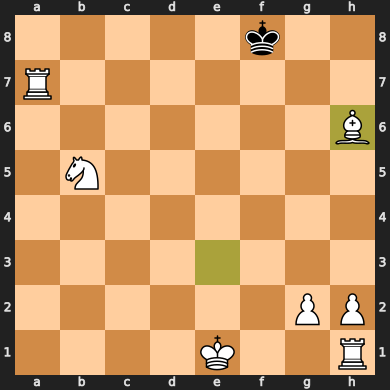

In [304]:
trainhistory[1][370][0].board

In [290]:
len(trainhistory)

15

In [353]:
c = 0
d = 0
#for iteration in trainhistory:
for position in trainhistory[13]:


    #print(position[0].board.fen())
    #print(position[0])
    c += 1 
    if "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w - - 0 1" == position[0].board.fen():
        d += 1
        print(position[0])

        print(position)
print(c)

white-4-2-3-5-6-3-2-4-1-1-1-1-1-1-1-1000000000000000000000000000000001111111142356324
(<antichess3.AntiChessLogic.Board object at 0x000002AC362C6508>, array([0., 0., 0., ..., 0., 0., 0.]), -1)
white-4-2-3-5-6-3-2-4-1-1-1-1-1-1-1-1000000000000000000000000000000001111111142356324
(<antichess3.AntiChessLogic.Board object at 0x000002AC35D6BA08>, array([0., 0., 0., ..., 0., 0., 0.]), 1)
white-4-2-3-5-6-3-2-4-1-1-1-1-1-1-1-1000000000000000000000000000000001111111142356324
(<antichess3.AntiChessLogic.Board object at 0x000002AC353B2B08>, array([0., 0., 0., ..., 0., 0., 0.]), -1)
white-4-2-3-5-6-3-2-4-1-1-1-1-1-1-1-1000000000000000000000000000000001111111142356324
(<antichess3.AntiChessLogic.Board object at 0x000002AC33E69308>, array([0., 0., 0., ..., 0., 0., 0.]), 1)
white-4-2-3-5-6-3-2-4-1-1-1-1-1-1-1-1000000000000000000000000000000001111111142356324
(<antichess3.AntiChessLogic.Board object at 0x000002AC338662C8>, array([0., 0., 0., ..., 0., 0., 0.]), -1)
white-4-2-3-5-6-3-2-4-1-1-1-1-1-1-1-1

white-4-2-3-5-6-3-2-4-1-1-1-1-1-1-1-1000000000000000000000000000000001111111142356324
(<antichess3.AntiChessLogic.Board object at 0x000002AA7E3B1E08>, array([0., 0., 0., ..., 0., 0., 0.]), -1)
white-4-2-3-5-6-3-2-4-1-1-1-1-1-1-1-1000000000000000000000000000000001111111142356324
(<antichess3.AntiChessLogic.Board object at 0x000002AAD1AAD788>, array([0., 0., 0., ..., 0., 0., 0.]), 1)
white-4-2-3-5-6-3-2-4-1-1-1-1-1-1-1-1000000000000000000000000000000001111111142356324
(<antichess3.AntiChessLogic.Board object at 0x000002AABC62B1C8>, array([0., 0., 0., ..., 0., 0., 0.]), 1)
white-4-2-3-5-6-3-2-4-1-1-1-1-1-1-1-1000000000000000000000000000000001111111142356324
(<antichess3.AntiChessLogic.Board object at 0x000002AAA5715148>, array([0., 0., 0., ..., 0., 0., 0.]), 1)
white-4-2-3-5-6-3-2-4-1-1-1-1-1-1-1-1000000000000000000000000000000001111111142356324
(<antichess3.AntiChessLogic.Board object at 0x000002AAF3CEF9C8>, array([0., 0., 0., ..., 0., 0., 0.]), -1)
white-4-2-3-5-6-3-2-4-1-1-1-1-1-1-1-10

In [1]:
examples = c.trainExamplesHistory
move_num = 0
iteration = 0
print(sum(examples[iteration][move_num][1]))
actions = np.nonzero(examples[iteration][move_num][1])[0]
actions = [action for action in actions]
print(actions)
for action in actions:
    print(get_move_from_action(action))
print("legal_moves_len:",len(list(examples[iteration][move_num][0].board.legal_moves)))
print(len(actions))
print(examples[iteration][move_num][0].board.fen())
#print(examples[iteration][move_num][0].board.is_game_over())
#print(examples[iteration][move_num][0].board.is_fivefold_repetition())
#print(examples[iteration][move_num][0].board.is_fifty_moves())

#actions = np.where(global_valids[move_num+1] != 0)[0]
#for action in actions:
#    print(get_move_from_action(action))

print(examples[iteration][move_num][0].pieces)
examples[iteration][move_num][0].board

NameError: name 'c' is not defined

In [42]:
def from_piece_map_to_pieces():

    square_at_index = 0
    for i in reversed(range(0, 8)):
        for j in range(0, 8):
            try:
                color = board.piece_at(square=square_at_index).color
                piece_type = board.piece_at(square=square_at_index).piece_type
                if color == False:
                    piece_type = piece_type * (-1)
            except:
                piece_type = 0
            pieces[i][j] = piece_type
            square_at_index = square_at_index + 1

In [17]:
import logging
import numpy as np
import random
from tqdm import tqdm
import chess
import chess.pgn
            

log = logging.getLogger(__name__)


class Arena():
    """
    An Arena class where any 2 agents can be pit against each other.
    """

    def __init__(self, player1, player2,game,fen,games_file,display=None):
        """
        Input:
            player 1,2: two functions that takes board as input, return action
            game: Game object
            display: a function that takes board as input and prints it (e.g.
                     display in othello/OthelloGame). Is necessary for verbose
                     mode.
        see othello/OthelloPlayers.py for an example. See pit.py for pitting
        human players/other baselines with each other.
        """
        
        self.player1 = player1
        self.player2 = player2
        self.game = game
        self.display = display
        self.mean_centi_pawn_loss_player1 = []
        self.mean_centi_pawn_loss_player2 = []
        self.blunders_player1 = []
        self.blunders_player2 = []
        self.stockfish_analysis_thinking_time = 0.01
        self.fen = fen
        self.game_to_write = open(games_file,"w")

        
    def set_analysis_thinking_time(self,time):
        self.stockfish_analysis_thinking_time = time


    def playGame(self, verbose=True):
        """
        Executes one episode of a game.
        Returns:
            either
                winner: player who won the game (1 if player1, -1 if player2)
            or
                draw result returned from the game that is neither 1, -1, nor 0.
        """

        engine = chess.engine.SimpleEngine.popen_uci("C:/Users/jerne/Downloads/fairy-stockfish-largeboard_x86-64.exe")
        centi_pawn_loss_player1 = []
        centi_pawn_loss_player2 = []

        players = [self.player2, None, self.player1]
        curPlayer = 1
        board = self.game.getInitBoard()
        board.set_fen(self.fen)
        it = 0
        while self.game.getGameEnded(board, curPlayer) == 0:
            it += 1
            if verbose:
                assert self.display
                print("Turn ", str(it), "Player ", str(curPlayer))
                self.display(board)
            action = players[curPlayer + 1](self.game.getCanonicalForm(board, curPlayer))
                        
            possible_moves = self.get_move_evaluation(engine, board.board, time_per_move=self.stockfish_analysis_thinking_time)

            if players[curPlayer + 1] == self.player1:
                move_centi_pawn = possible_moves[self.get_move_from_action(action)]
                best_centi_pawn = possible_moves[(max(possible_moves, key=possible_moves.get))]
                centi_pawn_diff_player1 = move_centi_pawn - best_centi_pawn
                if centi_pawn_diff_player1 < -100000:
                    self.blunders_player1.append(centi_pawn_diff_player1)
                    centi_pawn_diff_player1 = 0 # if blunder we set it to 0
                centi_pawn_loss_player1.append(centi_pawn_diff_player1)

            else:
                move_centi_pawn = possible_moves[self.get_move_from_action(action)]
                best_centi_pawn = possible_moves[(max(possible_moves, key=possible_moves.get))]
                centi_pawn_diff_player2 = move_centi_pawn - best_centi_pawn
                if centi_pawn_diff_player2 < -100000:
                    self.blunders_player2.append(centi_pawn_diff_player2)
                    centi_pawn_diff_player2 = 0 # if blunder we set it to 0
                centi_pawn_loss_player2.append(centi_pawn_diff_player2)


            valids = self.game.getValidMoves(self.game.getCanonicalForm(board, curPlayer), 1)

            #hack, that needs to be removed
            if valids[action] == 0:
                print("HACK")
                valid_actions = np.where(valids == 1)
                action = random.choice(valid_actions[0])

            if valids[action] == 0:

                print(valids)
                print(action)
                print(board.pieces)
                print(board.board.fen())
                print(curPlayer)
                move = int2base(action, 8, 4)
                move = FILE_MAP_REVERSE[move[0]] + "" + RANK_MAP_REVERSE[move[1]] + "" + FILE_MAP_REVERSE[move[2]] + "" + RANK_MAP_REVERSE[move[3]]
                print(move)
                moves1 = []
                for move1 in board.board.legal_moves:
                    moves1.append(list(str(move1)))
                print(moves1)
                log.error(f'Action {action} is not valid!')
                log.debug(f'valids = {valids}')
                assert valids[action] > 0
            board, curPlayer = self.game.getNextState(board, curPlayer, action)
        if verbose:
            assert self.display
            print("Game over: Turn ", str(it), "Result ", str(self.game.getGameEnded(board, 1)))
            self.display(board)

        engine.quit()
        #print("player1 avg_cpl:", np.mean(centi_pawn_loss_player1))
        #print("player2 avg_cpl:", np.mean(centi_pawn_loss_player2))
        self.mean_centi_pawn_loss_player1.append(np.mean(centi_pawn_loss_player1))
        self.mean_centi_pawn_loss_player2.append(np.mean(centi_pawn_loss_player2))
        game_pgn = chess.pgn.Game().from_board(board.board)
        #print(game_pgn)
        self.game_to_write.write("\n\n"+str(game_pgn)+"\n\n")
    
        return curPlayer * self.game.getGameEnded(board, curPlayer)

    def playGames(self, num, verbose=False):
        """
        Plays num games in which player1 starts num/2 games and player2 starts
        num/2 games.
        Returns:
            oneWon: games won by player1
            twoWon: games won by player2
            draws:  games won by nobody
        """

        num = int(num / 2)
        oneWon = 0
        twoWon = 0
        draws = 0
        for _ in tqdm(range(num), desc="Arena.playGames (1)"):
            gameResult = self.playGame(verbose=verbose)
            if gameResult == 1:
                oneWon += 1
            elif gameResult == -1:
                twoWon += 1
            else:
                draws += 1

        self.player1, self.player2 = self.player2, self.player1
        self.mean_centi_pawn_loss_player1, self.mean_centi_pawn_loss_player2 = self.mean_centi_pawn_loss_player2, self.mean_centi_pawn_loss_player1
        self.blunders_player1, self.blunders_player2 = self.blunders_player2,self.blunders_player1
        
        for _ in tqdm(range(num), desc="Arena.playGames (2)"):
            gameResult = self.playGame(verbose=verbose)
            if gameResult == -1:
                oneWon += 1
            elif gameResult == 1:
                twoWon += 1
            else:
                draws += 1

        print("total player1 avg_cpl:", np.mean(self.mean_centi_pawn_loss_player2))
        print("total player2 avg_cpl:", np.mean(self.mean_centi_pawn_loss_player1))
        self.game_to_write.close()
        return oneWon, twoWon, draws

    def get_move_evaluation(self,engine, board, time_per_move=0.01):
        list_moves = []
        for el in board.legal_moves:
            info = engine.analyse(board, chess.engine.Limit(time=time_per_move), root_moves=[el])
            t = str(info["score"])
            # print(el,info["score"].pov(board.turn).score(mate_score=1000000),t)
            list_moves.append((str(el), info["score"].pov(board.turn).score(mate_score=1000000)))

        sorted_list_moves = sorted(list_moves, key=lambda x: x[1], reverse=True)
        # for move in sorted_list_moves:
        #    print(move)
        return dict(sorted_list_moves)

    def get_move_from_action(self,action):
        if action in REVERSE_PROMOTIONS:
            move = REVERSE_PROMOTIONS[action]

        else:
            move = int2base(action, 8, 4)
            move = FILE_MAP_REVERSE[move[0]] + "" + RANK_MAP_REVERSE[move[1]] + "" + FILE_MAP_REVERSE[move[2]] + "" + \
                   RANK_MAP_REVERSE[move[3]]

        return move

In [44]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
def myFunc(e):
    try:
        model_index = int(e.split(".")[0].split("_")[-1])
    except:
        model_index = 201
    return model_index

In [45]:
def testing_agents(agent1_name,
                   agent2_name,
                   fen,
                   model_type,
                   num_of_games,
                   num_mcsts,
                   cpuct,
                   temp,
                   model,
                   stockfish_thinking_time,
                   stockfish_analysis_thinking_time,
                   random,
                   skill_lvl,
                   iteration):
    
            print(agent1_name,agent2_name,num_mcsts,stockfish_thinking_time,iteration,skill_lvl)

            player1_names = []
            player2_names = []
            games_per_iter = []
            player1_wins = []
            player2_wins = []
            draws = []
            player1_blunders = []
            player2_blunders = []
            centipawn_loss_player1 = []
            centipawn_loss_player2 = []
            time_per_iter = []
            
            alphaZeroType = ""
            agent1,agent2 = None,None
            results_name = ""
            games_file_name = ""
            
            g = AntiChessGame(8)
            n1 = NNetWrapper(g)
            
            if model_type == "Final":
                alphaZeroType = "Final"
                n1.load_checkpoint('./temp/antichess/final/torch/',model)
            else:
                alphaZeroType = "Reduced"
                n1.load_checkpoint('./temp/antichess/reduced_moves/torch/QROOKSKINGPAWNSFRONTx200x100x50/',model)
                
                
            args1 = dotdict({'numMCTSSims': num_mcts, 'cpuct':cpuct})
            mcts1 = MCTS(g, n1, args1)
            agent1 = lambda x: np.argmax(mcts1.getActionProb(x, temp=temp))
               
           
            if random:
                agent2 = RandomPlayer(g).play
                results_name = "./results/Type="+alphaZeroType+agent1_name+"Version="+str(model)+"#MCTS="+str(num_mcsts)+"cpuct="+str(cpuct)+"temp="+str(temp)+"#GAMES="+str(num_of_games)+"SkillLevel="+str(skill_lvl)+"vsRandomPlayerRESULTS.txt"
                games_file_name = "./games/Type="+alphaZeroType+agent1_name+"Version="+str(model)+"#MCTS="+str(num_mcsts)+"cpuct="+str(cpuct)+"temp="+str(temp)+"#GAMES="+str(num_of_games)+"SkillLevel="+str(skill_lvl)+"vsRandomPlayerGAMES.txt"
            else:
                agent2 = StockFishPlayer(g,stockfish_thinking_time,skill_lvl).play
                results_name = "./results/Type="+alphaZeroType+agent1_name+"Version="+str(model)+"#MCTS="+str(num_mcsts)+"cpuct="+str(cpuct)+"temp="+str(temp)+"#GAMES="+str(num_of_games)+"vsStockfisTime="+str(stockfish_thinking_time)+"SkillLevel="+str(skill_lvl)+"RESULTS.txt"
                games_file_name = "./games/Type="+alphaZeroType+agent1_name+"Version="+str(model)+"#MCTS="+str(num_mcsts)+"cpuct="+str(cpuct)+"temp="+str(temp)+"#GAMES="+str(num_of_games)+"vsStockfishTime="+str(stockfish_thinking_time)+"SkillLevel="+str(skill_lvl)+"GAMES.txt"


            arena = Arena(player1=agent1,player2=agent2,game=g,fen=fen,games_file=games_file_name)
            arena.set_analysis_thinking_time(stockfish_analysis_thinking_time)

            start = time.time()
            results = arena.playGames(num_of_games,verbose=False)

            end = time.time()
            print(end-start)
            time_per_iter.append(end-start)
            games_per_iter.append(num_of_games)
            player1_wins.append(results[0])
            player2_wins.append(results[1])
            draws.append(results[2])
            player1_names.append(agent1_name)
            player2_names.append(agent2_name)
            centipawn_loss_player1.append(np.mean(arena.mean_centi_pawn_loss_player2))
            centipawn_loss_player2.append(np.mean(arena.mean_centi_pawn_loss_player1))
            player2_blunders.append(len(arena.blunders_player1))
            player1_blunders.append(len(arena.blunders_player2))

            results_df = pd.DataFrame({"iteration" : iteration,
                                       "number_of_games" : games_per_iter,
                                       "time_per_iter":time_per_iter,
                                       "player1name":agent1_name,
                                       "player2name":agent2_name,
                                       "model" : model,
                                       "#MCTS" : num_mcts,
                                       "cpuct" : cpuct,
                                       "temp" : temp,
                                       "StockfishTime" : stockfish_thinking_time,
                                       "SkillLevel" : skill_lvl,
                                       "player1_wins" : player1_wins,
                                       "player2_wins":player2_wins,
                                       "draws" : draws,
                                       "centipawn_loss_player1": centipawn_loss_player1,
                                       "centipawn_loss_player2": centipawn_loss_player2,
                                       "blunders_player1" : player1_blunders, 
                                       "blunders_player2" : player2_blunders})    
            
            results_df.to_csv(results_name)


In [50]:
#PLAYING GAMES
models = models
mcts_sims = [150]
stockfish_thinking_times = [0.001]
skill_levels = [5]
cpucts = [1.0]
temps = [0]
agent1_name = "AlphaZero"
agent2_name = "Stockfish"
fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w - - 0 1"
model_type = "Final"
num_of_games = 12
stockfish_analysis_thinking_time = 0.01
random = False


for model in models[735:]:
    for num_mcts in mcts_sims:
        for stockfish_thinking_time in stockfish_thinking_times:
            for cpuct in cpucts:
                for temp in temps:
                    for skill_lvl in skill_levels:
                        iteration = 0
                        testing_agents(agent1_name=agent1_name,
                                       agent2_name=agent2_name,
                                       fen=fen,
                                       model_type=model_type,
                                       num_of_games=num_of_games,
                                       num_mcsts=num_mcts,
                                       cpuct=cpuct,
                                       temp=temp,
                                       model=model,
                                       stockfish_thinking_time=stockfish_thinking_time,
                                       stockfish_analysis_thinking_time=stockfish_analysis_thinking_time,
                                       random=random,
                                       skill_lvl=skill_lvl,
                                       iteration=iteration)

AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [04:55<00:00, 49.33s/it]


total player1 avg_cpl: -67.96288771994982
total player2 avg_cpl: -53.401509040830014
455.0121352672577
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [01:50<00:00, 18.49s/it]


total player1 avg_cpl: -87.76963735532352
total player2 avg_cpl: -70.07620063974552
226.59238576889038
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [02:02<00:00, 20.47s/it]


total player1 avg_cpl: -76.08266198790143
total player2 avg_cpl: -73.9152130176898
241.29137444496155
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [01:50<00:00, 18.49s/it]


total player1 avg_cpl: -68.19283499151919
total player2 avg_cpl: -58.18140004273906
221.34424257278442
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [01:59<00:00, 19.93s/it]


total player1 avg_cpl: -106.06847793794725
total player2 avg_cpl: -106.2080022226282
234.1739046573639
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [02:32<00:00, 25.41s/it]


total player1 avg_cpl: -69.95322804472816
total player2 avg_cpl: -48.219766749263876
298.00951647758484
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [04:05<00:00, 40.96s/it]


total player1 avg_cpl: -63.638663152358816
total player2 avg_cpl: -64.71870678153469
445.33710169792175
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [03:53<00:00, 38.86s/it]


total player1 avg_cpl: -76.15040350763574
total player2 avg_cpl: -72.94720580133911
483.6125657558441
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [03:53<00:00, 38.98s/it]


total player1 avg_cpl: -74.57285418589582
total player2 avg_cpl: -46.0801808875822
437.1985809803009
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [04:49<00:00, 48.26s/it]


total player1 avg_cpl: -59.044749391778375
total player2 avg_cpl: -54.703099259144985
580.8614282608032
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [02:23<00:00, 23.91s/it]


total player1 avg_cpl: -89.77100856967849
total player2 avg_cpl: -75.24445917989968
259.3638858795166
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [02:48<00:00, 28.14s/it]


total player1 avg_cpl: -113.21098376261419
total player2 avg_cpl: -100.41284950472023
311.5582392215729
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [02:25<00:00, 24.19s/it]


total player1 avg_cpl: -85.22292106119548
total player2 avg_cpl: -64.76502675993035
360.57088351249695
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [04:02<00:00, 40.49s/it]


total player1 avg_cpl: -84.53952225646066
total player2 avg_cpl: -88.51501880768184
518.8629291057587
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [03:00<00:00, 30.12s/it]


total player1 avg_cpl: -78.46679148625547
total player2 avg_cpl: -53.36813999490977
420.42824268341064
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [03:11<00:00, 31.94s/it]


total player1 avg_cpl: -76.92127310893615
total player2 avg_cpl: -72.8414530972572
345.2388813495636
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [03:33<00:00, 35.63s/it]


total player1 avg_cpl: -51.47509441381101
total player2 avg_cpl: -54.986068638039875
443.4662735462189
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [03:37<00:00, 36.28s/it]


total player1 avg_cpl: -75.74723196881091
total player2 avg_cpl: -71.9719056012046
450.3094685077667
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [04:25<00:00, 44.28s/it]


total player1 avg_cpl: -65.25710911135597
total player2 avg_cpl: -55.21537306110642
476.4992218017578
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [03:09<00:00, 31.60s/it]


total player1 avg_cpl: -81.89024623903141
total player2 avg_cpl: -57.19666197891101
367.8013949394226
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [02:13<00:00, 22.20s/it]


total player1 avg_cpl: -69.48468650258123
total player2 avg_cpl: -75.23687131395745
369.2957534790039
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [03:15<00:00, 32.52s/it]


total player1 avg_cpl: -78.132391129402
total player2 avg_cpl: -65.79931917384816
405.6638197898865
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [03:49<00:00, 38.19s/it]


total player1 avg_cpl: -61.01207598562225
total player2 avg_cpl: -40.26722964310188
401.84534740448
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [03:56<00:00, 39.34s/it]


total player1 avg_cpl: -71.19058535668385
total player2 avg_cpl: -55.2556477581933
408.0239644050598
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (1):  83%|████████████████████████████████████████████████████▌          | 5/6 [03:33<00:42, 42.11s/it]2021-11-03 12:47:33 DESKTOP-P47V2S9 __main__[29084] ERROR All valid moves were masked, doing a workaround.
2021-11-03 12:47:33 DESKTOP-P47V2S9 __main__[29084] ERROR All valid moves were masked, doing a workaround.
Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [03:43<00:00, 37.19s/it]


total player1 avg_cpl: -86.07029412711621
total player2 avg_cpl: -64.90031815375065
475.3401653766632
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|███████████████████████████████████████████████████████████████| 6/6 [04:05<00:00, 40.93s/it]


total player1 avg_cpl: -70.6181320020136
total player2 avg_cpl: -59.07363654217329
515.4636468887329


In [ ]:
#OBSERVING RESULTS
models = ["checkpoint_499.pth.tar"]
mcts_sims = [300,500]
stockfish_thinking_times = [0.0001]
skill_levels = [-1,0,1,2,3,4,5,6,7,8]
cpucts = [1.0,1.25,2]
temps = [0,1,2]
agent1_name = "AlphaZero"
agent2_name = "Stockfish"
fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w - - 0 1"
model_type = "Final"
num_of_games = 10
stockfish_analysis_thinking_time = 0.01
random = False

frames = []

for model in models:
    for num_mcts in mcts_sims:
        for s_time in stockfish_thinking_times:
            for cpuct in cpucts:
                for temp in temps:
                    for skill_lvl in skill_levels:
                        result_path = "results/Type="+str(model_type)+agent1_name+"Version="+str(model)+"#MCTS="+str(num_mcts)+"cpuct="+str(cpuct)+"temp="+str(temp)+"#GAMES="+str(num_of_games)+"vsStockfisTime="+str(s_time)+"SkillLevel="+str(skill_lvl)+"RESULTS.txt"
                        try:
                            df_result = pd.read_csv(result_path)                                             
                            frames.append(df_result)
                        except:
                            print("error")

output = pd.concat(frames)          

In [48]:
import os
models = os.listdir("C:/Users/jerne/Documents/MasterThesis/temp/antichess/final/torch")
models = list(set(models) - set(['best.pth.tar','temp.pth.tar','trainhistory.pth.tar.examples']))
models.sort(key=myFunc)

In [293]:
def from_piece_map_to_pieces():

        square_at_index = 0
        for i in reversed(range(0, 8)):
            for j in range(0, 8):
                try:
                    color = board.piece_at(square=square_at_index).color
                    piece_type = board.piece_at(square=square_at_index).piece_type
                    if color == False:
                        piece_type = piece_type * (-1)
                except:
                    piece_type = 0
                self.pieces[i][j] = piece_type
                square_at_index = square_at_index + 1

In [450]:
can_boards = [
    "white-4-2-3-5-6-3-2-4-1-1-1-1-1-1-1-1000000000000000000000000000000001111111142356324",
    "white0-200-60-2-400-1-100-3-100000000000000000000000000101000100000014206002-3",
    "black0-200-60-2-400-1-100-3-100000000000000000000000000101000100200014006002-3",
    "white0-200-60-2-400-1-1000-100000000000000000000000000-301000100200014006002-3",
    "black0-200-60-2-400-1-1000-100000000000000000000000000-301000100220014006000-3",
    "white0-200-60-2-400-1-1000-100000000000000000000000000001000100-320014006000-3",
    "black0-200-60-2-400-1-1000-100000000000000000000000000001000100620014000000-3",
    "white0-2000-6-2-400-1-1000-100000000000000000000000000001000100620014000000-3",
    "black0-2000-6-2-400-1-1000-1000000000000000000000000000010001006200100000004",
    "white0-2000-6-2-400-1-100000000000-10000000000000000000010001006200100000004",
    "black0-2000-6-2-400-1-100000000000-10000000000000000000010001006200100004000",
    "white0-20000-2-400-1-100-600000000-10000000000000000000010001006200100004000",
    "black0-20000-2-400-1-100-600000000-10000000000001000000000001006200100004000",
    "white0-20000-2-400-1-1000000000-60-10000000000001000000000001006200100004000",
    "black0-20000-2-400-1-1000000000-60-10000000000001000000000001000200100604000",
    "white0-200000-400-1-1-200000000-60-10000000000001000000000001000200100604000",
    "black0-200000-400-1-1-200000000-60-10000000000001000000000001006200100004000",
    "white0000000-400-1-1-2000-20000-60-10000000000001000000000001006200100004000",
    "black0000000-400-1-1-2000-20000-60-10000000000001000000000001006200100000004",
    "white0000000-400-1-10000-20-200-60-10000000000001000000000001006200100000004",
    "black0000000-400-1-10000-20-200-60-10000000000001000006000001000200100000004",
    "white0000000-400-1-10000-20-20000-1000000-6000001000006000001000200100000004",
    "black0000000-400-1-10000-20-20000-1000000-6000021000006000001000000100000004",
    "white0000000-400-1-10000-2000000-1000000-60000-21000006000001000000100000004"
]



71


In [451]:
b_new = chess.variant.AntichessBoard()

In [452]:
b_new.set_piece_map(dict_board)

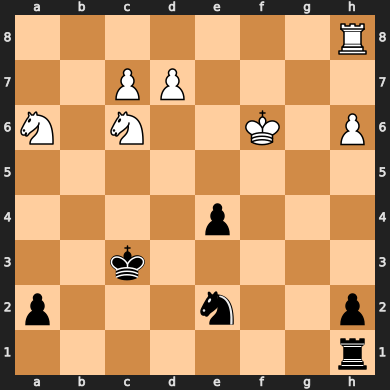

In [453]:
b_new

In [454]:
b_new.fen()

'7R/2PP4/N1N2K1P/8/4p3/2k5/p3n2p/7r w - - 0 1'

In [455]:
def from_canonical_to_actual(canonical_board):
    c_b = canonical_board
    pos = c_b[5:]
    ply = c_b[:5]

    board = []
    final_board = np.zeros((8,8)).astype(int)
    counter = 0
    i = 0
    for _ in range(len(pos)-5):
        if i >= len(pos):
            break
        piece = 0
        if pos[i] == "-":
            piece = pos[i]+pos[i+1]
            i = i + 1
        else:
            piece = pos[i]
        i = i + 1
        board.append(int(piece))

    for j in range(0,64,8):
        final_board[counter] = board[j:j+8]
        counter += 1

    square_at_index = 0
    dict_board = {}
    for i in reversed(range(0, 8)):
        for j in range(0, 8):
            piece = final_board[i][j]

            if piece != 0:

                dict_board[square_at_index] = chess.Piece.from_symbol(REVERSE_PIECE_MAP[piece])

            square_at_index = square_at_index + 1
           
    
    return dict_board